# Machine Learning: Assignment #2

Bárbara Nóbrega Galiza – 202408654​

Cláudia Oliveira - 202005668​

Marta Campos - 202008344

## Introduction

In this project we aim to predict the LOS (lenght of stay) of an ICU stay for a particular disease, knowing only data from the 1st day of stay for the patient. That means we use limited data available only on the first day. The dataset used is MIMIC-III, where the diseases are labeled by ICD-9 codes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from charlson import *
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, make_scorer, root_mean_squared_error, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import shap
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

c:\Users\claud\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Choosing disease

First we find the 15 most frequent diagnosis codes in the dataset and map them to the descriptions. The goal is to understand disease prevalence in order to select our target disease.

In [2]:
# Diagnoses
diag = pd.read_csv('tables/DIAGNOSES_ICD.csv')

# Diagnoses and their descriptions
desc = pd.read_csv('tables/D_ICD_DIAGNOSES.csv')

top_codes = diag['ICD9_CODE'].value_counts().head(15).reset_index()
top_codes.columns = ['ICD9_CODE', 'count']

top_diseases = top_codes.merge(desc[['ICD9_CODE', 'SHORT_TITLE']], on='ICD9_CODE', how='left')

print(top_diseases)

   ICD9_CODE  count               SHORT_TITLE
0       4019  20703          Hypertension NOS
1       4280  13111                   CHF NOS
2      42731  12891       Atrial fibrillation
3      41401  12429  Crnry athrscl natve vssl
4       5849   9119  Acute kidney failure NOS
5      25000   9058  DMII wo cmp nt st uncntr
6       2724   8690    Hyperlipidemia NEC/NOS
7      51881   7497  Acute respiratry failure
8       5990   6555  Urin tract infection NOS
9      53081   6326         Esophageal reflux
10      2720   5930   Pure hypercholesterolem
11      V053   5779  Need prphyl vc vrl hepat
12      V290   5519    NB obsrv suspct infect
13      2859   5406                Anemia NOS
14      2449   4917        Hypothyroidism NOS


Based on the previous results we initialy selected Congestive Heart Failure (CHF) as our disease of interest, since it was the second most frequent diagnosis in the dataset. However, in order to have sufficient records to work with, we included every variation of heart failure by selecting all ICD-9 codes starting with '428' (this is a MACRO disease). 

Then we filtered for hospitalizations where heart failure was listed as the primary diagnosis (SEQ_NUM == 1.0). This ensures our analysis focuses on admissions primarily driven by HF. From this filtered dataset, we extracted the corresponding hospital admission IDs (HADM_ID) and patient IDs (SUBJECT_ID), which will be used to filter other clinical tables like CHARTEVENTS to include only relevant records.

In [3]:
diag['ICD9_CODE'] = diag['ICD9_CODE'].astype(str)
d = diag[diag['ICD9_CODE'].str.startswith('428')]

diagnoses_disease = d[d['SEQ_NUM'] == 1.0].copy()
hadm_ids = diagnoses_disease['HADM_ID'].unique()
patients_ids = diagnoses_disease['SUBJECT_ID'].unique()

To efficiently handle the large CHARTEVENTS dataset, we read it in 100000 row chunks, filtering each chunk to keep only clinical events linked to hospital admissions for heart failure patients. After concatenating these filtered chunks, we print the number of primary heart failure diagnoses (by admission) and check how many clinical event records correspond to those admissions.

In [4]:
chunksize = 100000 
filtered_chunks = []

for chunk in pd.read_csv('tables/CHARTEVENTS.csv', chunksize=chunksize, low_memory=False):
    chunk = chunk[chunk['HADM_ID'].isin(hadm_ids)]
    filtered_chunks.append(chunk)

chartevents_filtered = pd.concat(filtered_chunks)

In [5]:
print(len(diagnoses_disease))
len(chartevents_filtered)

1488


986502

The numbers indicate there is enough data to proceed.

## Data Preprocessing

We are going to load the datasets regarding patient demographic information, hospital admissions, and ICU stays, filtering each to include only heart failure patients identified earlier. We also load a dictionary to map clinical event codes (ITEMID) to their descriptions. Finally, we print counts of ICU stays, admissions, and patients in our filtered data to verify dataset sizes.

In [6]:
# Patient demographic information
patients = pd.read_csv('tables/PATIENTS.csv')
patients = patients[patients['SUBJECT_ID'].isin(patients_ids)]

# Hospital admissions 
admissions = pd.read_csv('tables/ADMISSIONS.csv')
admissions = admissions[admissions['HADM_ID'].isin(hadm_ids)]

icustays = pd.read_csv('tables/ICUSTAYS.csv')
icustays = icustays[icustays['HADM_ID'].isin(hadm_ids)]

# Dictionary that maps ITEMIDs to their names/descriptions
items = pd.read_csv('tables/D_ITEMS.csv')

In [7]:
print(len(icustays))
print(len(admissions)) # one diagnose by admission
print(len(patients))

1623
1488
1268


#### Comorbidities

In this step, we analyze comorbidities for heart failure admissions. We start by filtering the diagnosis data to include only non-primary diagnoses (i.e., additional conditions beyond heart failure). Then, for each hospital admission, we group the ICD-9 codes of these secondary diagnoses and use them to calculate the Charlson Comorbidity Index (CCI). A higher CCI score indicates a higher burden of illness and a greater risk of adverse outcomes, such as death or ICU complications, which might be a valuable feature.



In [8]:
diag_all = diag[diag['HADM_ID'].isin(hadm_ids) & (diag['SEQ_NUM'] > 1)]
grouped = diag_all.groupby('HADM_ID')['ICD9_CODE'].apply(list).reset_index()

grouped['charlson_cat'] = grouped['ICD9_CODE'].apply(mapear_charlson)
grouped['charlson_index'] = grouped['charlson_cat'].apply(calcular_cci)
grouped.head(5)

,HADM_ID,ICD9_CODE,charlson_cat,charlson_index
0,100050,"[99811, 5990, 4241, 41401, 2875, 99791, 42731,...",{},0
1,100061,"[5849, 4160, 4280, 496, 25060, 3572, 4439, V45...","{PVD, DiabComp, CHF}",4
2,100136,"[51882, 486, 42731, 4019, 2724, 45829, E9444, ...",{},0
3,100182,"[5849, 5854, 7455, 2761, 4139, 4280, 496, V667...","{Diabetes, PVD, Renal, CHF}",5
4,100199,"[51881, 2800, 5781, 42789, 5563, 7806, 25000, ...",{Diabetes},1


We extract the second (SEQ_NUM == 2) and third (SEQ_NUM == 3) comorbidities from the DIAGNOSES_ICD table. These represent the most significant conditions in addition to heart failure for each admission. We merged them into our main dataset and filled in 0 where no secondary diagnoses were available.

In [9]:
diag_seq2 = diag[diag['SEQ_NUM'] == 2.0][['HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'comorbidity1'})
diagnoses_disease = diagnoses_disease.merge(diag_seq2, on='HADM_ID', how='left')
diagnoses_disease['comorbidity1'] = diagnoses_disease['comorbidity1'].fillna(0)

diag_seq2 = diag[diag['SEQ_NUM'] == 3.0][['HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'comorbidity2'})
diagnoses_disease = diagnoses_disease.merge(diag_seq2, on='HADM_ID', how='left')
diagnoses_disease['comorbidity2'] = diagnoses_disease['comorbidity2'].fillna(0)

diagnoses_disease.head(15)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,comorbidity1,comorbidity2
0,2154,175,176764,1.0,42831,51881,5070
1,2163,176,135828,1.0,4280,42731,4251
2,2172,177,143120,1.0,4280,51881,5119
3,2460,199,185360,1.0,4280,4254,4240
4,3596,305,122211,1.0,42820,99859,5070
5,2056,165,170252,1.0,42823,51881,49121
6,2516,205,135671,1.0,4280,4240,5990
7,4092,351,174800,1.0,4280,78057,6110
8,3775,323,106158,1.0,4280,99672,99762
9,3784,323,128132,1.0,4280,78551,51881


This block analyzes the most common first comorbidities among heart failure patients. We compute how much of the total comorbidity frequency is explained by the top 5 ICD-9 codes and visualize the top 100 in a bar chart. This helps assess whether the comorbidity profile is concentrated or widely distributed across different conditions.

Percentage of the frequency explained by the top 5 comorbities: 44.01881720430107 %


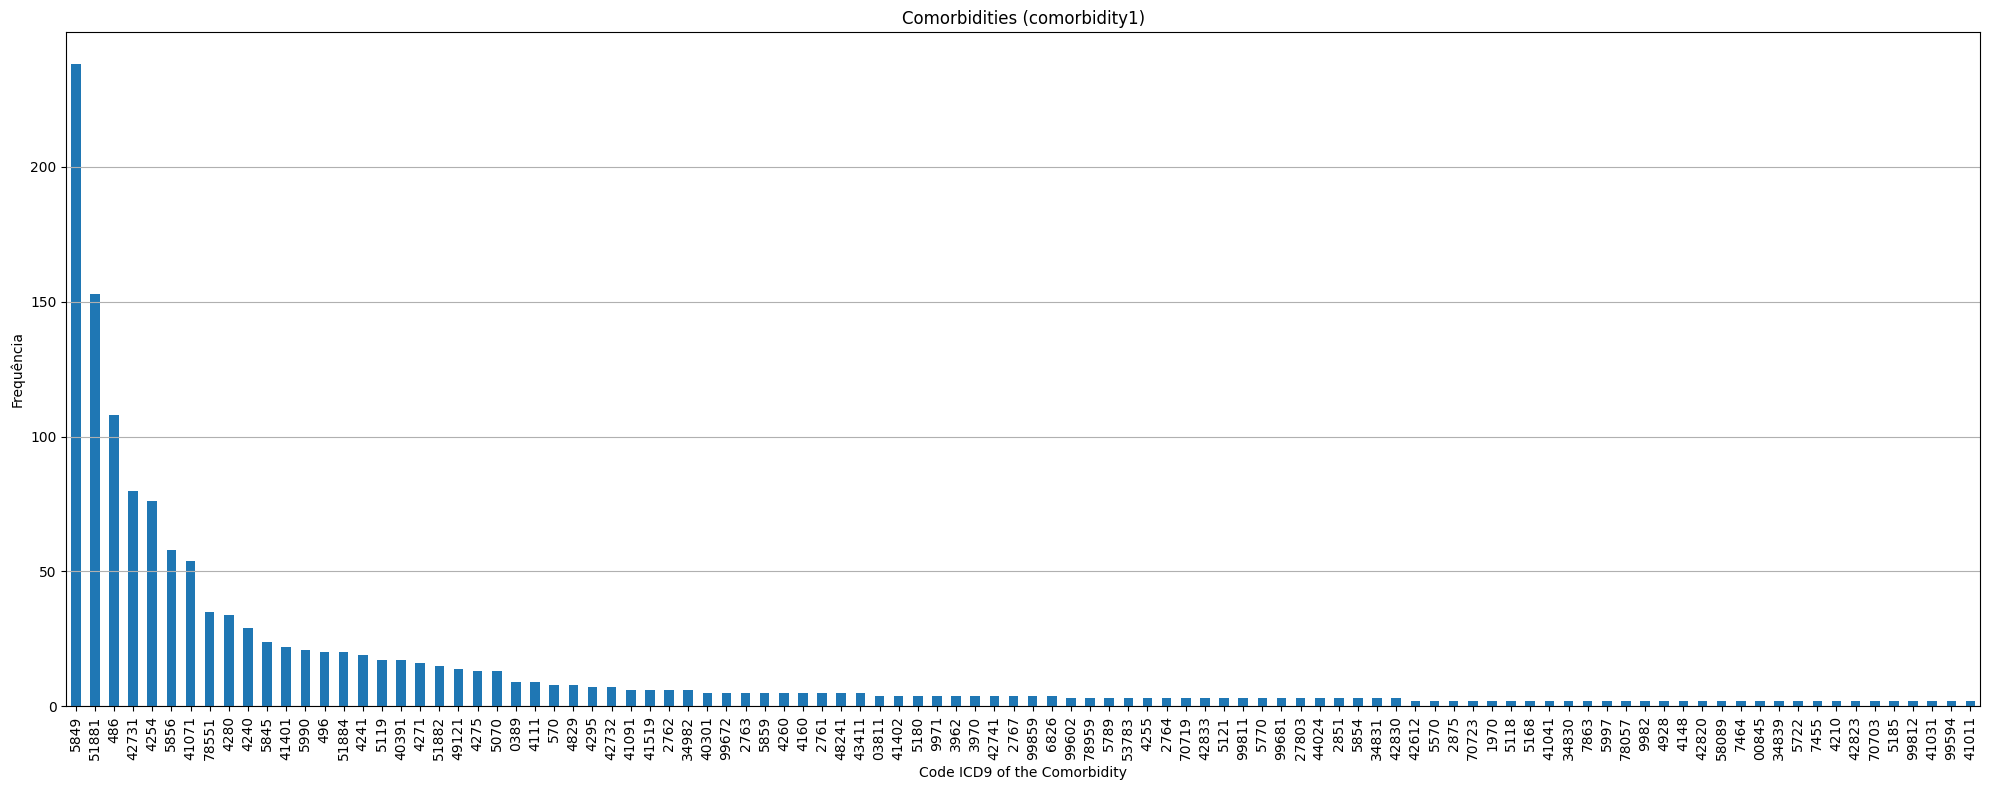

comorbidity1
5849     238
51881    153
486      108
42731     80
4254      76
Name: count, dtype: int64

In [10]:
counts1 = diagnoses_disease['comorbidity1'].value_counts()

c1 = sum(counts1[0:5])/sum(counts1[:]) 
print("Percentage of the frequency explained by the top 5 comorbities: " + str(c1*100) + " %")

plt.figure(figsize=(20,8))
counts_plot = counts1[0:100]
counts_plot.plot(kind='bar')
plt.title('Comorbidities (comorbidity1)')
plt.xlabel('Code ICD9 of the Comorbidity')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

counts1[0:5]

The data is highly skewed: a small number of comorbidities represent a significant percentage of all recorded first comorbidities. This means that certain health conditions occur much more frequently than others in heart failure patients. These common comorbidities are known to be closely linked to heart failure and can have a major impact on how patients respond to treatment and how their disease progresses, so we decided to use them as columns.

We repeat the frequency analysis for the third most important diagnosis (comorbidity2).

Percentage of the frequency explained by the top 5 comorbities2: 26.478494623655912 %


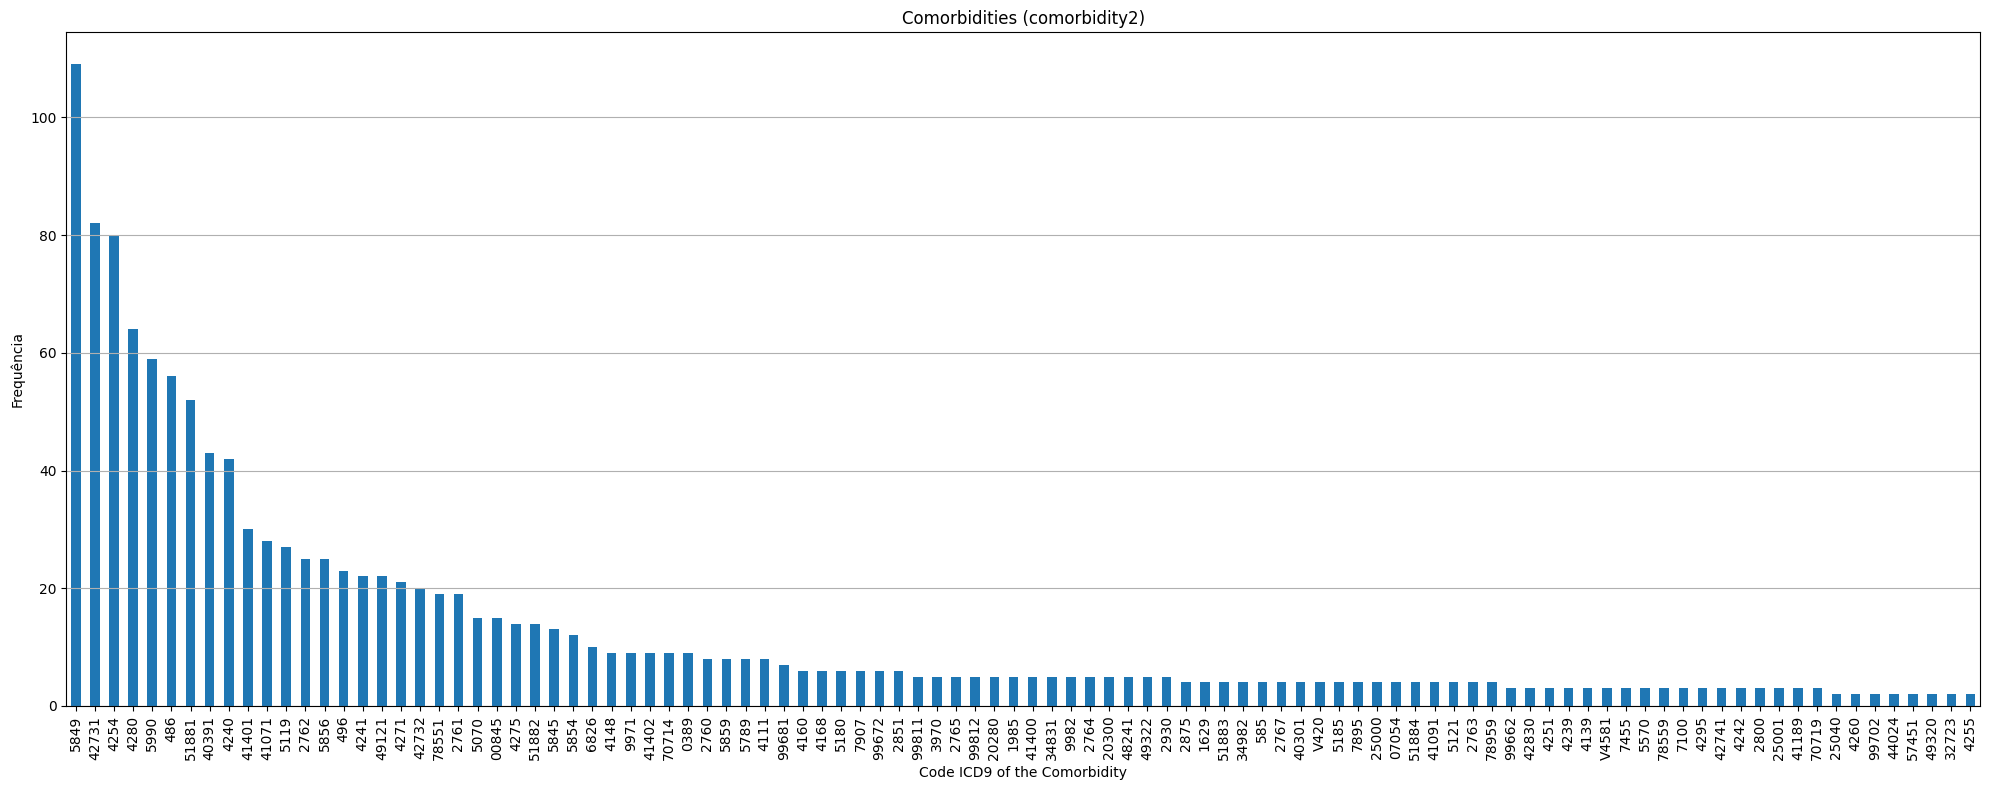

comorbidity2
5849     109
42731     82
4254      80
4280      64
5990      59
Name: count, dtype: int64

In [11]:
counts2 = diagnoses_disease['comorbidity2'].value_counts()

c2 = sum(counts2[0:5])/sum(counts2) 
print("Percentage of the frequency explained by the top 5 comorbities2: " + str(c2*100) + " %")

plt.figure(figsize=(20,8))
counts_plot = counts2[0:100]
counts_plot.plot(kind='bar')
plt.title('Comorbidities (comorbidity2)')
plt.xlabel('Code ICD9 of the Comorbidity')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

counts2[0:5]

While comorbidity1 was heavily concentrated in just a few ICD-9 codes (with the top 5 dominating the dataset), comorbidity2 displays a more gradual decline in frequency. This suggests that the second comorbidity is more varied across patients, with no single condition overwhelmingly dominating the list.

Still, some patterns persist. This reinforces the idea that certain complications consistently co-occur with heart failure, regardless of their position in the comorbidity list. Therefore we will also use this top 5 as columns.

Structure of the datasets so far:

In [12]:
print(f"Columns of Diagnosis: {diag.columns} \n")
print(f"Columns of Description of Diseases: {desc.columns} \n")
print(f"Columns of ICU Stays: {icustays.columns} \n")
print(f"Columns of Chart Events: {chartevents_filtered.columns} \n")
print(f"Columns of Patients: {patients.columns} \n")
print(f"Columns of Admissions: {admissions.columns} \n")

Columns of Diagnosis: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object') 

Columns of Description of Diseases: Index(['ROW_ID', 'ICD9_CODE', 'SHORT_TITLE', 'LONG_TITLE'], dtype='object') 

Columns of ICU Stays: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS'],
      dtype='object') 

Columns of Chart Events: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME',
       'STORETIME', 'CGID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'WARNING',
       'ERROR', 'RESULTSTATUS', 'STOPPED'],
      dtype='object') 

Columns of Patients: Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object') 

Columns of Admissions: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHAR

## Data Preparation

To prepare the comorbidity information for modeling, we focus on the top 5 most frequent diagnoses listed as the second and third diagnosis for each heart failure admission (comorbidity1 and comorbidity2, respectively).

For both comorbidity columns, we:
* Identify the top 5 most frequent ICD-9 codes.
* Create a new column that retains only these top 5 codes, labeling all others as "Other".
* Apply one-hot encoding (pd.get_dummies) to generate binary variables for each of the top codes.
* Remove the "Other" column to avoid adding noise.
* Concatenate these dummy variables back into the main diagnoses_disease DataFrame.

This process transforms categorical ICD-9 codes into a numerical format suitable for machine learning models, while keeping the feature space interpretable and focused on the most clinically relevant comorbidities.

In [13]:
top5 = diagnoses_disease['comorbidity1'].value_counts().index[:5]

diagnoses_disease['comorbidity1_top5'] = diagnoses_disease['comorbidity1'].where(
    diagnoses_disease['comorbidity1'].isin(top5), other='Other'
)

dummies = pd.get_dummies(diagnoses_disease['comorbidity1_top5'], prefix='comorbidity1')
dummies = dummies.drop(columns=['comorbidity1_Other'], errors='ignore')

diagnoses_disease = pd.concat([diagnoses_disease, dummies], axis=1)

In [14]:
top5 = diagnoses_disease['comorbidity2'].value_counts().index[:5]

diagnoses_disease['comorbidity2_top5'] = diagnoses_disease['comorbidity2'].where(
    diagnoses_disease['comorbidity2'].isin(top5), other='Other'
)

dummies = pd.get_dummies(diagnoses_disease['comorbidity2_top5'], prefix='comorbidity2')
dummies = dummies.drop(columns=['comorbidity2_Other'], errors='ignore')

diagnoses_disease = pd.concat([diagnoses_disease, dummies], axis=1)

In [15]:
len(diagnoses_disease)
diagnoses_disease.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,comorbidity1,comorbidity2,comorbidity1_top5,comorbidity1_4254,comorbidity1_42731,comorbidity1_486,comorbidity1_51881,comorbidity1_5849,comorbidity2_top5,comorbidity2_4254,comorbidity2_42731,comorbidity2_4280,comorbidity2_5849,comorbidity2_5990
0,2154,175,176764,1.0,42831,51881,5070,51881,False,False,False,True,False,Other,False,False,False,False,False
1,2163,176,135828,1.0,4280,42731,4251,42731,False,True,False,False,False,Other,False,False,False,False,False
2,2172,177,143120,1.0,4280,51881,5119,51881,False,False,False,True,False,Other,False,False,False,False,False
3,2460,199,185360,1.0,4280,4254,4240,4254,True,False,False,False,False,Other,False,False,False,False,False
4,3596,305,122211,1.0,42820,99859,5070,Other,False,False,False,False,False,Other,False,False,False,False,False


To analyze only the clinical data collected during the first 24 hours of ICU stay, we start by converting the INTIME (ICU admission time) and CHARTTIME (event timestamp) columns to datetime format. We then merge the CHARTEVENTS data with the ICUSTAYS table using the ICUSTAY_ID to align each event with its corresponding ICU stay.

After the merge, we calculate the time difference (in days) between each event and the ICU admission time. Any events recorded before ICU admission are corrected by setting their time difference to zero.

Finally, we filter the dataset to retain only events that occurred within the first 24 hours of ICU admission (which is our window size). We investigated [this](https://eatlas.escardio.org/Data/Cardiovascular-healthcare-delivery/Heart-failure-health-care/hfe_avgstay-average-length-of-stay-in-hospital-primarily-due-to-hf?utm_source=chatgpt.com) link and the data revealed to be originaly from Israel and further analysis indicated that many patients are discharged after the first 24 hours. As a result, including data beyond this period would not be ideal for our study.

In [16]:
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
chartevents_filtered['CHARTTIME'] = pd.to_datetime(chartevents_filtered['CHARTTIME'])

# Merge on ICUSTAY_ID or HADM_ID depending on your data
merged = pd.merge(chartevents_filtered, icustays[['ICUSTAY_ID', 'INTIME']], on='ICUSTAY_ID', how='inner')

# Compute time difference
merged['DAYS_FROM_INTIME'] = (merged['CHARTTIME'] - merged['INTIME']).dt.total_seconds() / 86400
merged.loc[merged['DAYS_FROM_INTIME'] < 0, 'DAYS_FROM_INTIME'] = 0

# Filter for events within the first 24 hours
chartevents_first_day = merged[merged['DAYS_FROM_INTIME'] < 1].copy()

In [17]:
chartevents_filtered.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
20387,27124,165,170252,247247.0,223761,2170-10-03 18:00:00,2170-10-03 18:43:00,16187.0,97.3,97.3,?F,0.0,0.0,NaN,NaN
20388,27125,165,170252,247247.0,225664,2170-10-03 18:00:00,2170-10-03 18:43:00,20277.0,174.0,174.0,NaN,0.0,0.0,NaN,NaN
20389,27126,165,170252,247247.0,220277,2170-10-03 18:35:00,2170-10-03 18:43:00,16187.0,99.0,99.0,%,0.0,0.0,NaN,NaN
20390,27127,165,170252,247247.0,220045,2170-10-03 18:36:00,2170-10-03 18:43:00,16187.0,73.0,73.0,bpm,0.0,0.0,NaN,NaN
20391,27128,165,170252,247247.0,220210,2170-10-03 18:36:00,2170-10-03 18:43:00,16187.0,19.0,19.0,insp/min,0.0,0.0,NaN,NaN


In [18]:
#num of clinical event records collected during the first 24 hours of ICU stay
print(len(chartevents_first_day))
chartevents_first_day.head()

274508


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,INTIME,DAYS_FROM_INTIME
0,27124,165,170252,247247.0,223761,2170-10-03 18:00:00,2170-10-03 18:43:00,16187.0,97.3,97.3,?F,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.029248
1,27125,165,170252,247247.0,225664,2170-10-03 18:00:00,2170-10-03 18:43:00,20277.0,174.0,174.0,NaN,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.029248
2,27126,165,170252,247247.0,220277,2170-10-03 18:35:00,2170-10-03 18:43:00,16187.0,99.0,99.0,%,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.053553
3,27127,165,170252,247247.0,220045,2170-10-03 18:36:00,2170-10-03 18:43:00,16187.0,73.0,73.0,bpm,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.054248
4,27128,165,170252,247247.0,220210,2170-10-03 18:36:00,2170-10-03 18:43:00,16187.0,19.0,19.0,insp/min,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.054248


### Some visualizations

To explore how long patients typically stay in the ICU, we visualize the distribution of Length of Stay (LOS) using a histogram. We first calculate the maximum LOS and round it up to determine the range of the x-axis. Then, we plot a histogram with 1-day bin widths, showing how frequently each LOS value appears in the dataset. This helps us to understand the overall distribution and typical lengths of stay in the ICU for our group of patients.

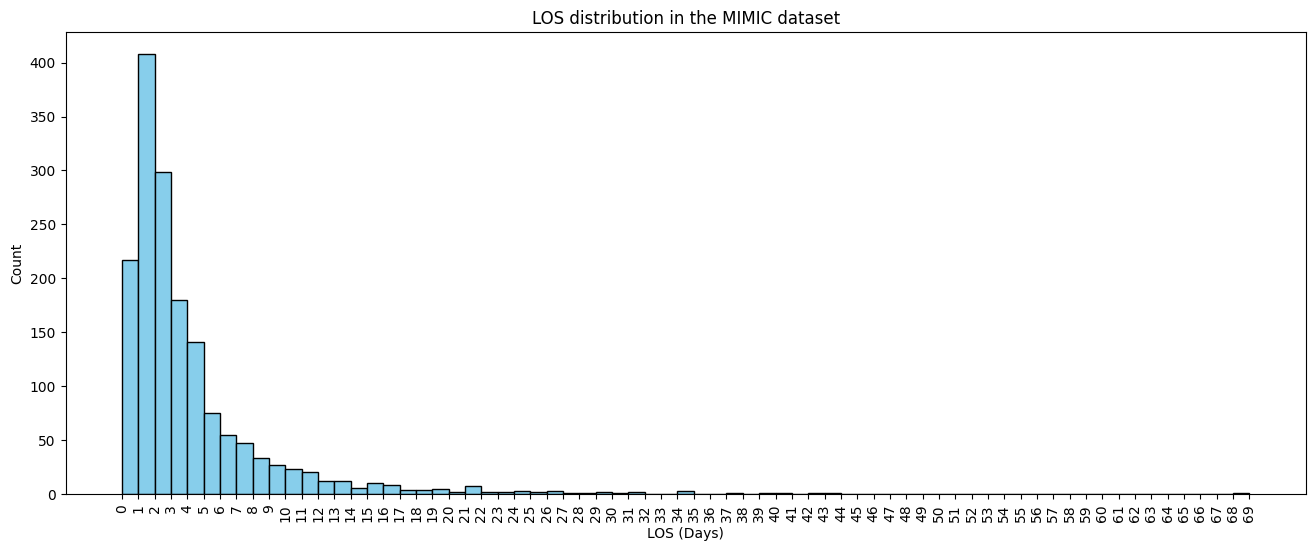

In [19]:
max_los = int(np.ceil(icustays["LOS"].max()))

plt.figure(figsize=(16, 6))
plt.hist(icustays["LOS"], bins=np.arange(0, max_los + 1, 1), edgecolor='black', color='skyblue')
plt.title("LOS distribution in the MIMIC dataset")
plt.ylabel("Count")
plt.xlabel("LOS (Days)")
plt.xticks(np.arange(0, max_los + 1, step=1), rotation=90)
plt.show()

We observed that most patients typically stay between 1 and 5 days. Very long stays (over 20 days) are rare. This indicates that ICU admissions are generally short, and a small number of patients account for extended stays.
However, one patient stood out by remaining hospitalized for 69 days. This unusual case lead us to investigate further.

List of patient IDs with Length of Stay (LOS) greater that 68 days

In [20]:
print(icustays.loc[icustays["LOS"] > 68, "SUBJECT_ID"])

11353    8868
Name: SUBJECT_ID, dtype: int64


To better understand the unusually long ICU stay identified earlier (over 68 days), we isolate the records for SUBJECT_ID 8868 across multiple tables. We count how many ICU stays, hospital admissions, and diagnosis records are associated with this patient. This allows us to investigate whether the outlier is due to repeated hospitalizations, a data entry issue, or a genuinely complex clinical case.

In [21]:
icu_outliers = icustays[icustays['SUBJECT_ID']==8868]
adm_outliers = admissions[admissions['SUBJECT_ID']==8868]

num_icustays = icu_outliers.shape[0]
num_admissions = adm_outliers.shape[0]

print(f"Number of ICU stays for SUBJECT_ID 8868: {num_icustays}")
print(f"Number of admissions for SUBJECT_ID 8868: {num_admissions}")

diag_outliers = diag[diag['SUBJECT_ID'] == 8868]
num_diagnoses = diag_outliers.shape[0]

print(f"Number of diagnosis records for SUBJECT_ID 8868: {num_diagnoses}")

Number of ICU stays for SUBJECT_ID 8868: 1
Number of admissions for SUBJECT_ID 8868: 1
Number of diagnosis records for SUBJECT_ID 8868: 18


The results reveal that the patient had only been admitted on that occasion, but they had 18 diseases at the same time, which is extremely severe.

In [22]:
print(any(chartevents_filtered['SUBJECT_ID'] == 8868))

False


Although patient 8868 was identified as an outlier, they do not appear in the filtered CHARTEVENTS dataset.

To better understand the clinical profile of the outlier patient (SUBJECT_ID 8868), we enrich their diagnosis records by merging with the ICD9 diagnosis description table. This allows us to view both the short and long textual descriptions for each diagnosis, providing clearer insight into their medical conditions.

In [23]:
diag_outliers2 = diag_outliers.merge(desc[['ICD9_CODE', 'SHORT_TITLE','LONG_TITLE']], on="ICD9_CODE", how="left")
diag_outliers2

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,98941,8868,181556,1.0,4280,CHF NOS,"Congestive heart failure, unspecified"
1,98942,8868,181556,2.0,4240,Mitral valve disorder,Mitral valve disorders
2,98943,8868,181556,3.0,42731,Atrial fibrillation,Atrial fibrillation
3,98944,8868,181556,4.0,5185,NaN,NaN
4,98945,8868,181556,5.0,5845,"Ac kidny fail, tubr necr",Acute kidney failure with lesion of tubular ne...
5,98946,8868,181556,6.0,4271,Parox ventric tachycard,Paroxysmal ventricular tachycardia
6,98947,8868,181556,7.0,4254,Prim cardiomyopathy NEC,Other primary cardiomyopathies
7,98948,8868,181556,8.0,53642,Gastrostomy comp - mech,Mechanical complication of gastrostomy
8,98949,8868,181556,9.0,40391,Hyp kid NOS w cr kid V,"Hypertensive chronic kidney disease, unspecifi..."
9,98950,8868,181556,10.0,5770,Acute pancreatitis,Acute pancreatitis


To ensure the reliability of our analysis, we remove ICU stays that last longer than 68 days.

In [24]:
icustays = icustays[icustays["LOS"] < 68]

To understand which clinical variables are most frequently recorded during the first 24 hours of ICU stay, we analyze the number of unique patients associated with each ITEMID in the chartevents_first_day dataset. This gives insight into the most commonly monitored clinical measurements. We then visualize the top 100 most frequently measured items.

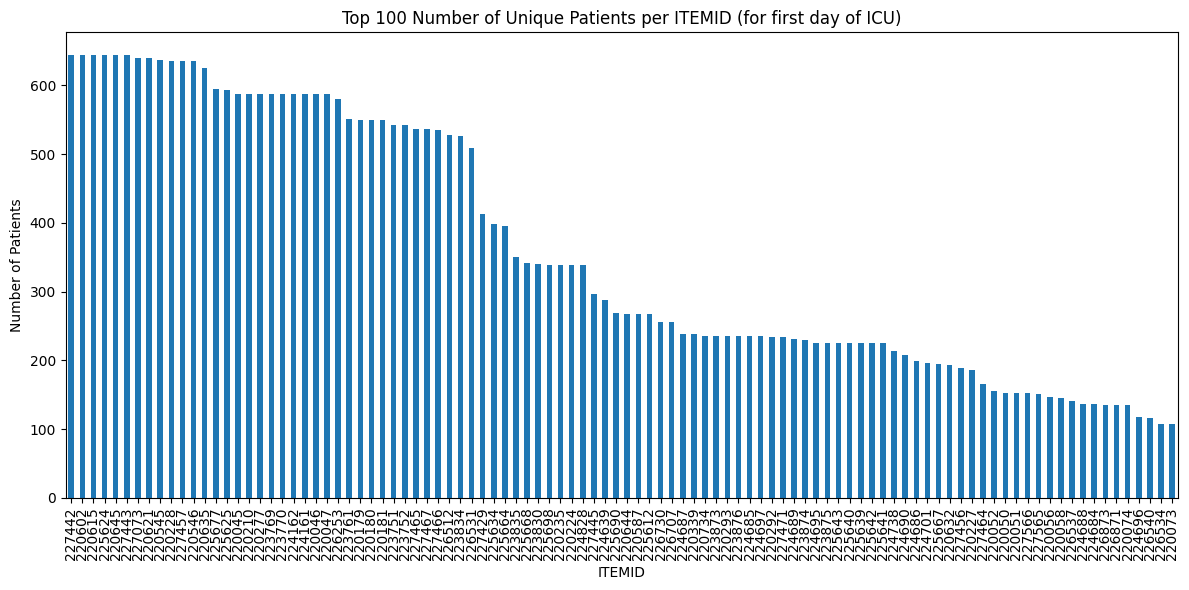

In [25]:
patients_per_item = chartevents_first_day.groupby('ITEMID')['SUBJECT_ID'].nunique().sort_values(ascending=False)[0:100]

plt.figure(figsize=(12, 6))
patients_per_item.plot(kind='bar')
plt.title('Top 100 Number of Unique Patients per ITEMID (for first day of ICU)')
plt.xlabel('ITEMID')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.show()

The most frequent variables appear in over 600 patients, suggesting they are standard measurements in ICU care. The distribution then gradually declines, indicating that while some variables are routinely collected, others are only recorded in specific cases. This information helps prioritize variables for analysis based on availability and coverage across patients.

We analyze how many different types of clinical measurements (ITEMIDs) were recorded during the first 24 hours of ICU stay for each patient. This helps assess the richness and completeness of data available per stay. By plotting this distribution, we can identify how many ICU stays have a sufficient number of clinical variables for potential use in predictive modeling. A red horizontal line at 25 variables highlights a possible threshold for filtering stays with limited clinical data.

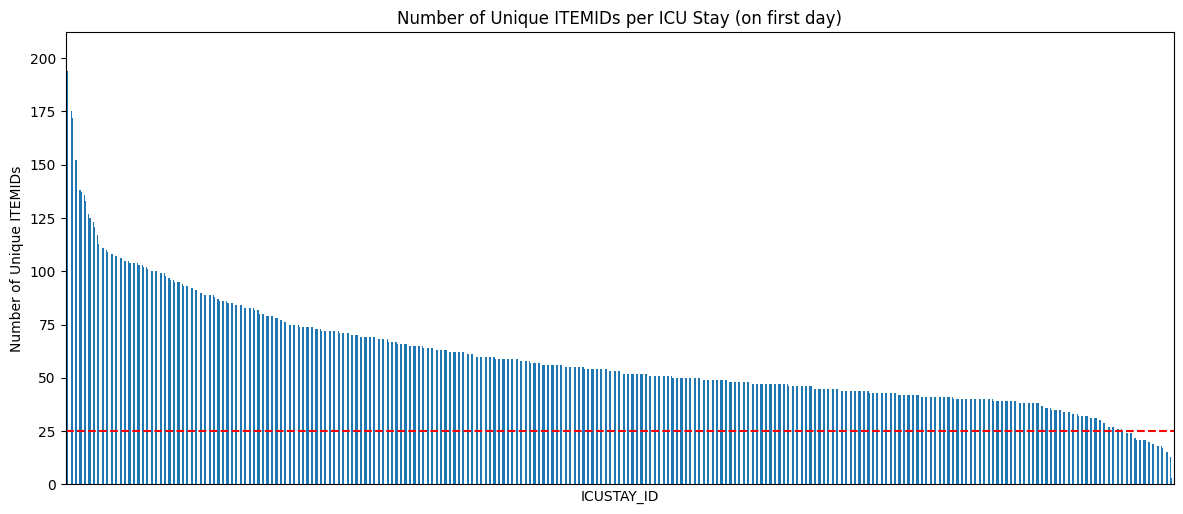

In [26]:
items_per_patient = chartevents_first_day.groupby('ICUSTAY_ID')['ITEMID'].nunique().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
items_per_patient.plot(kind='bar')
plt.title('Number of Unique ITEMIDs per ICU Stay (on first day)')
plt.xlabel('ICUSTAY_ID')
plt.ylabel('Number of Unique ITEMIDs')
plt.tight_layout()
plt.axhline(y=25, color='red', linestyle='--', linewidth=1.5)
plt.xticks([]) 
plt.show()

The plot shows that most ICU stays include at least 25 different measurements (ITEMIDs) on the first day. This suggests a high level of clinical monitoring early in the ICU stay, which is beneficial for downstream tasks such as risk prediction, as it provides a rich set of data for each patient.

We explore how many ICU stays each patient has experienced by grouping the data by patient and counting their ICU admissions. The resulting distribution shows how common it is for patients to have multiple ICU stays.

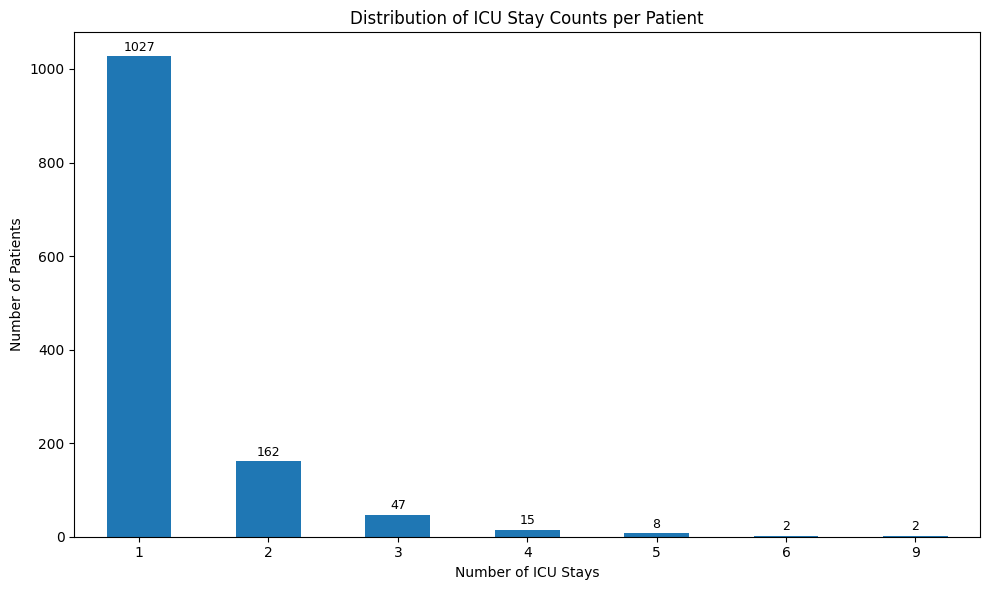

In [27]:
stays_by_patient = icustays.groupby('SUBJECT_ID')['ICUSTAY_ID'].nunique().sort_values(ascending=False)

stay_counts = stays_by_patient.value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = stay_counts.plot(kind='bar')
plt.title('Distribution of ICU Stay Counts per Patient')
plt.xlabel('Number of ICU Stays')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)

for i, value in enumerate(stay_counts):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

The plot reveals that the majority of patients have only one ICU stay, with 1027 patients falling into this category. Fewer patients experience multiple ICU stays.

Now we analyse how many ICU stays occur within each hospital admission. By grouping ICU stays based on the hospital admission ID, we count how many ICU stays are associated with each admission.

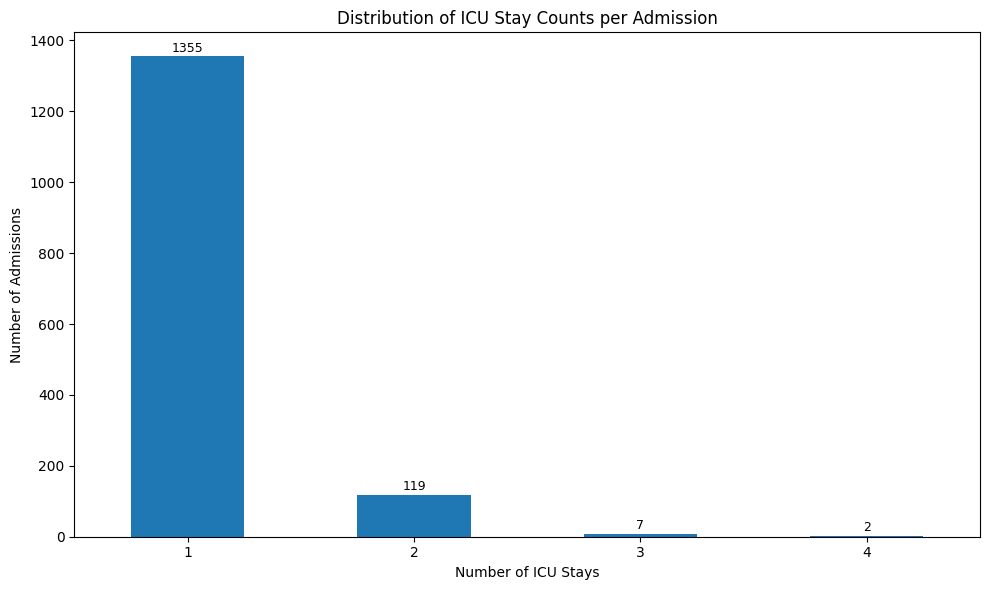

In [28]:
stays_by_adm = icustays.groupby('HADM_ID')['ICUSTAY_ID'].nunique().sort_values(ascending=False)

stay_counts = stays_by_adm.value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = stay_counts.plot(kind='bar')
plt.title('Distribution of ICU Stay Counts per Admission')
plt.xlabel('Number of ICU Stays')
plt.ylabel('Number of Admissions')
plt.xticks(rotation=0)

for i, value in enumerate(stay_counts):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

The plot shows that most hospital admissions involve a single ICU stay, with 1355 admissions falling into this category.

## Merging datasets

We built a comprehensive dataset starting from ICU stays, enriched progressively with detailed admission data, patient demographics, and comorbidity information. By merging the Charlson index and the top comorbidities, we capture the burden of illness for each patient admission. Finally, early clinical measurements from the first ICU day are included to provide critical physiological context. Checking dataset length after each step helps us maintain data integrity throughout the merges.

In [29]:
dataset = icustays[['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS']]

print(len(dataset))

dataset = dataset.merge(admissions[['HADM_ID', 'ADMITTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']], on=['HADM_ID'], how='left')

dataset = dataset.merge(grouped[['HADM_ID','charlson_index']], on=['HADM_ID'], how='left')

print(len(dataset))

dataset = dataset.merge(patients[['SUBJECT_ID', 'GENDER', 'DOB']], on='SUBJECT_ID', how='left')

print(len(dataset))

dataset = dataset.merge(diagnoses_disease[["HADM_ID", "comorbidity1_4254",	"comorbidity1_42731","comorbidity1_486","comorbidity1_51881","comorbidity1_5849","comorbidity2_4254","comorbidity2_4280",	"comorbidity2_42731",	"comorbidity2_5849",	"comorbidity2_5990"]], on="HADM_ID", how="left")
#dataset = dataset.merge(diagnoses_disease[["HADM_ID", "comorbidity1","comorbidity2"]], on="HADM_ID", how="left")

print(len(dataset))

dataset = dataset.merge(chartevents_first_day[['ICUSTAY_ID', 'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'DAYS_FROM_INTIME']], on=['ICUSTAY_ID'], how="left")

print(len(dataset))


dataset.columns

1622
1622
1622
1622
275271


Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMITTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'charlson_index', 'GENDER', 'DOB',
       'comorbidity1_4254', 'comorbidity1_42731', 'comorbidity1_486',
       'comorbidity1_51881', 'comorbidity1_5849', 'comorbidity2_4254',
       'comorbidity2_4280', 'comorbidity2_42731', 'comorbidity2_5849',
       'comorbidity2_5990', 'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM',
       'DAYS_FROM_INTIME'],
      dtype='object')

To assess the quality and structure of the dataset, we start by printing its total size to ensure completeness after all merges. We then inspect the number of unique values per column, which gives insight into feature variability. Finally, we check for missing values across all columns. Identifying missing data is a critical step before modeling or statistical analysis, as it may affect model performance or bias results if not handled appropriately.

In [30]:
print(len(dataset))
print(dataset.nunique())
dataset.isna().sum()

275271
ICUSTAY_ID             1622
SUBJECT_ID             1263
HADM_ID                1483
LOS                    1594
ADMITTIME              1483
ADMISSION_TYPE            3
ADMISSION_LOCATION        6
INSURANCE                 5
RELIGION                 16
MARITAL_STATUS            7
ETHNICITY                25
charlson_index           13
GENDER                    2
DOB                    1248
comorbidity1_4254         2
comorbidity1_42731        2
comorbidity1_486          2
comorbidity1_51881        2
comorbidity1_5849         2
comorbidity2_4254         2
comorbidity2_4280         2
comorbidity2_42731        2
comorbidity2_5849         2
comorbidity2_5990         2
ITEMID                  646
VALUE                  4246
VALUENUM               3231
VALUEUOM                 74
DAYS_FROM_INTIME      30326
dtype: int64


ICUSTAY_ID                0
SUBJECT_ID                0
HADM_ID                   0
LOS                       0
ADMITTIME                 0
ADMISSION_TYPE            0
ADMISSION_LOCATION        0
INSURANCE                 0
RELIGION                329
MARITAL_STATUS         2683
ETHNICITY                 0
charlson_index            0
GENDER                    0
DOB                       0
comorbidity1_4254         0
comorbidity1_42731        0
comorbidity1_486          0
comorbidity1_51881        0
comorbidity1_5849         0
comorbidity2_4254         0
comorbidity2_4280         0
comorbidity2_42731        0
comorbidity2_5849         0
comorbidity2_5990         0
ITEMID                  763
VALUE                  1966
VALUENUM              12532
VALUEUOM              23906
DAYS_FROM_INTIME        763
dtype: int64

To ensure the quality of our clinical time-series data, we filter out incomplete records. We first drop any rows where the ITEMID (which specifies the type of clinical measurement) is missing, as these rows cannot be interpreted meaningfully. Next, we remove rows where the VALUE column is missing, since a measurement without a value cannot contribute to analysis or modeling. These cleaning steps reduce noise and ensure that our dataset only includes complete and usable clinical observations.

In [31]:
dataset = dataset.dropna(subset=["ITEMID"])
print(dataset.isna().sum())
dataset = dataset.dropna(subset=["VALUE"])
print(dataset.isna().sum())

ICUSTAY_ID                0
SUBJECT_ID                0
HADM_ID                   0
LOS                       0
ADMITTIME                 0
ADMISSION_TYPE            0
ADMISSION_LOCATION        0
INSURANCE                 0
RELIGION                324
MARITAL_STATUS         2667
ETHNICITY                 0
charlson_index            0
GENDER                    0
DOB                       0
comorbidity1_4254         0
comorbidity1_42731        0
comorbidity1_486          0
comorbidity1_51881        0
comorbidity1_5849         0
comorbidity2_4254         0
comorbidity2_4280         0
comorbidity2_42731        0
comorbidity2_5849         0
comorbidity2_5990         0
ITEMID                    0
VALUE                  1203
VALUENUM              11769
VALUEUOM              23143
DAYS_FROM_INTIME          0
dtype: int64
ICUSTAY_ID                0
SUBJECT_ID                0
HADM_ID                   0
LOS                       0
ADMITTIME                 0
ADMISSION_TYPE            0
ADMISSI

After filtering out incomplete measurement rows, we examine the structure of the remaining dataset.

In [32]:
print(len(dataset))
print(dataset.nunique())

273305
ICUSTAY_ID              859
SUBJECT_ID              670
HADM_ID                 791
LOS                     847
ADMITTIME               791
ADMISSION_TYPE            3
ADMISSION_LOCATION        6
INSURANCE                 5
RELIGION                 16
MARITAL_STATUS            7
ETHNICITY                25
charlson_index           13
GENDER                    2
DOB                     669
comorbidity1_4254         2
comorbidity1_42731        2
comorbidity1_486          2
comorbidity1_51881        2
comorbidity1_5849         2
comorbidity2_4254         2
comorbidity2_4280         2
comorbidity2_42731        2
comorbidity2_5849         2
comorbidity2_5990         2
ITEMID                  642
VALUE                  4246
VALUENUM               3231
VALUEUOM                 74
DAYS_FROM_INTIME      30325
dtype: int64


We verified that no significant information was lost when the incomplete records were removed.

## Preprocessing categorical variables

#### Ethinicity

In [33]:
print(dataset.ETHNICITY.unique())

['WHITE' 'BLACK/AFRICAN AMERICAN' 'UNKNOWN/NOT SPECIFIED'
 'HISPANIC OR LATINO' 'ASIAN' 'OTHER' 'WHITE - RUSSIAN'
 'WHITE - BRAZILIAN' 'BLACK/HAITIAN' 'ASIAN - CHINESE'
 'WHITE - OTHER EUROPEAN' 'PORTUGUESE' 'UNABLE TO OBTAIN'
 'BLACK/CAPE VERDEAN' 'ASIAN - FILIPINO' 'ASIAN - CAMBODIAN'
 'AMERICAN INDIAN/ALASKA NATIVE' 'HISPANIC/LATINO - PUERTO RICAN'
 'PATIENT DECLINED TO ANSWER' 'ASIAN - ASIAN INDIAN' 'BLACK/AFRICAN'
 'HISPANIC/LATINO - DOMINICAN' 'WHITE - EASTERN EUROPEAN' 'MIDDLE EASTERN'
 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)']


To simplify the analysis and reduce fragmentation in the ethnicity data, we group detailed ethnicity labels into broader categories. We define a mapping that consolidates various ethnicity subtypes (e.g., “WHITE - RUSSIAN”, “BLACK/HAITIAN”) into general groups like "White", "Black", "Asian", or "Hispanic/Latino". Any ethnicity not explicitly listed in the mapping is categorized as "Other", ensuring no data is lost. This standardization helps in building more interpretable and statistically robust models by reducing the number of unique categories.

In [34]:
ethnicity_map = {
    'WHITE': 'White',
    'WHITE - RUSSIAN': 'White',
    'WHITE - BRAZILIAN': 'White',
    'WHITE - OTHER EUROPEAN': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',

    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/AFRICAN': 'Black',
    'BLACK/HAITIAN': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',

    'ASIAN': 'Asian',
    'ASIAN - CHINESE': 'Asian',
    'ASIAN - FILIPINO': 'Asian',
    'ASIAN - CAMBODIAN': 'Asian',
    'ASIAN - ASIAN INDIAN': 'Asian',

    'HISPANIC OR LATINO': 'Hispanic/Latino',
    'HISPANIC/LATINO - PUERTO RICAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - DOMINICAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)': 'Hispanic/Latino',

    'PORTUGUESE': 'Other',
    'MIDDLE EASTERN': 'Other',
    'AMERICAN INDIAN/ALASKA NATIVE': 'Other',

    'OTHER': 'Other',
    'UNABLE TO OBTAIN': 'Other',
    'UNKNOWN/NOT SPECIFIED': 'Other',
    'PATIENT DECLINED TO ANSWER': 'Other',
}
dataset['ETHNICITY_GROUPED'] = dataset['ETHNICITY'].map(ethnicity_map).fillna('Other')

#### Marital Status

In [35]:
print(dataset.MARITAL_STATUS.unique())

['MARRIED' 'WIDOWED' nan 'SINGLE' 'SEPARATED' 'DIVORCED' 'LIFE PARTNER'
 'UNKNOWN (DEFAULT)']


Similarly to how we grouped detailed ethnicity labels into broader categories, we also standardize the marital status information to reduce fragmentation and improve interpretability. For example, individuals labeled as "LIFE PARTNER" are grouped under "MARRIED", while "SEPARATED" is combined with "DIVORCED". Any unknown or missing entries are reassigned to a catch-all group labeled "UNKNOWN (DEFAULT)".

In [36]:
marital_map = {
    'MARRIED' : 'MARRIED',
    'LIFE PARTNER' : 'MARRIED',
    'WIDOWED' : 'WIDOWED',
    'DIVORCED' : 'DIVORCED',
    'SEPARATED' : 'DIVORCED',
    'UNKNOWN (DEFAULT)' : 'UNKNOWN (DEFAULT)',
    'SINGLE' : 'SINGLE'
}

dataset['MARITAL_STATUS'] = dataset['MARITAL_STATUS'].map(marital_map).fillna('UNKNOWN (DEFAULT)')
print(dataset.MARITAL_STATUS.unique())
dataset.MARITAL_STATUS.value_counts()

['MARRIED' 'WIDOWED' 'UNKNOWN (DEFAULT)' 'SINGLE' 'DIVORCED']


MARITAL_STATUS
MARRIED              131081
WIDOWED               60913
SINGLE                59174
DIVORCED              18955
UNKNOWN (DEFAULT)      3182
Name: count, dtype: int64

#### Religion

In [37]:
print(dataset.RELIGION.value_counts())

RELIGION
CATHOLIC               117475
JEWISH                  51526
NOT SPECIFIED           43810
PROTESTANT QUAKER       31686
UNOBTAINABLE             6740
EPISCOPALIAN             5637
OTHER                    4915
GREEK ORTHODOX           3725
BUDDHIST                 3012
MUSLIM                   1359
CHRISTIAN SCIENTIST       963
BAPTIST                   873
ROMANIAN EAST. ORTH       549
HINDU                     273
JEHOVAH'S WITNESS         259
7TH DAY ADVENTIST         222
Name: count, dtype: int64


To clean and consolidate the RELIGION variable, we group ambiguous or missing entries under a single "OTHER" category. 

In [38]:
dataset['RELIGION'] = dataset['RELIGION'].replace('UNOBTAINABLE', 'OTHER')
dataset['RELIGION'] = dataset['RELIGION'].replace('NOT SPECIFIED', 'OTHER')
dataset['RELIGION'] = dataset['RELIGION'].fillna('OTHER')

To incorporate patient age as a key demographic feature, we begin by converting the admission and birth dates into a datetime format, ensuring robust handling of any formatting errors. We define a function that calculates age at admission, applying special treatment for unrealistic dates of birth (e.g., future years due to anonymization) by capping the age at 89.

After computing the age, we filter out any records where age could not be determined. To streamline the dataset, we then drop the original DOB and ADMITTIME columns. This preparation allows us to analyze age as a clean numerical feature.

In [39]:
# 1. Convert 'ADMITTIME' and 'DOB' to datetime format (handle parsing errors as NaT)
dataset['ADMITTIME'] = pd.to_datetime(dataset['ADMITTIME'], errors='coerce')
dataset['DOB'] = pd.to_datetime(dataset['DOB'], errors='coerce')

dataset['AGE'] = None

def safe_calculate_age(row):
    try:
        if pd.isna(row['ADMITTIME']) or pd.isna(row['DOB']):
            return None
        if row['DOB'].year > 2200:
            return 89
        age = (row['ADMITTIME'] - row['DOB']).days / 365.242
        return 89 if age > 89 else age
    except Exception as e:
        return None

dataset['AGE'] = dataset.apply(safe_calculate_age, axis=1)

dataset['AGE'] = dataset['AGE'].fillna(200).astype(int)

dataset = dataset[dataset['AGE'] != 200]  # DROP

# 5. (opcional) dropa as colunas DOB e ADMITTIME
dataset.drop(columns=['DOB', 'ADMITTIME'], inplace=True)

# Verifica
print(dataset[['SUBJECT_ID', 'AGE']].head())

   SUBJECT_ID  AGE
0         305   74
1         305   74
2         305   74
3         305   74
4         305   74


To enhance the Charlson Comorbidity Index with age-related risk, we first compute an age-based score for each patient using the pontos_idade function. This function assigns points based on age brackets, consistent with the Charlson methodology. We then calculate the final Charlson Index by summing the age-based score with the original comorbidity index. Finally, we inspect the distribution of this combined score, which reflects the total health burden and helps stratify patients by risk level.

In [40]:
dataset['age_cat'] = dataset['AGE'].apply(pontos_idade)
dataset['CHARLSON_IND_FINAL'] = dataset['charlson_index'] + dataset['age_cat']
dataset['CHARLSON_IND_FINAL'].value_counts()

CHARLSON_IND_FINAL
6     43076
5     39132
7     37511
4     31357
8     28105
3     22212
9     11597
2     10681
1      6678
10     5338
11     4228
12      763
13      659
0       479
17      332
15      229
Name: count, dtype: int64

For example, 43076 patients have a final Charlson score of 6. The Charlson Index reflects a combination of chronic illness burden and age, so a score of 6 suggests a moderate to high predicted mortality risk.

In [41]:
print(len(dataset))
dataset.columns

242377


Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'charlson_index', 'GENDER', 'comorbidity1_4254',
       'comorbidity1_42731', 'comorbidity1_486', 'comorbidity1_51881',
       'comorbidity1_5849', 'comorbidity2_4254', 'comorbidity2_4280',
       'comorbidity2_42731', 'comorbidity2_5849', 'comorbidity2_5990',
       'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'DAYS_FROM_INTIME',
       'ETHNICITY_GROUPED', 'AGE', 'age_cat', 'CHARLSON_IND_FINAL'],
      dtype='object')

## Assessing correlations to select features

To explore relationships between features, we first prepare the dataset by applying one-hot encoding to categorical variables such as religion, marital status, insurance type, and others. This transforms them into binary columns suitable for numerical analysis.

We then drop identifiers and raw measurement values that are not meaningful for correlation computation. Using the Spearman method (useful for non-linear relationships and ordinal data), we compute a correlation matrix across all numerical and binary features to capture monotonic relationships, even if they are non-linear.

Finally, we visualize the correlation matrix using a color gradient, which helps quickly identify highly correlated variables, potential redundancies, or insightful associations for further analysis or feature selection.

In [42]:
dtemp = dataset.copy()
print(dtemp.columns)
from scipy.stats import mannwhitneyu

dtemp = pd.get_dummies(dtemp, columns=['RELIGION'])
dtemp = pd.get_dummies(dtemp, columns=['MARITAL_STATUS'])
dtemp = pd.get_dummies(dtemp, columns=['ETHNICITY_GROUPED'])
dtemp = pd.get_dummies(dtemp, columns=['ADMISSION_TYPE'])
dtemp = pd.get_dummies(dtemp, columns=['ADMISSION_LOCATION'])
dtemp = pd.get_dummies(dtemp, columns=['INSURANCE'])
dtemp = pd.get_dummies(dtemp, columns=['GENDER'], drop_first=True)

dtemp = dtemp.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM',
       'DAYS_FROM_INTIME', 'ETHNICITY'])

numerical_cols = [col for col in dtemp.columns if dtemp[col].nunique() > 2 and col != 'LOS']

corr_los_numeric = dtemp[numerical_cols + ['LOS']].corr(method="spearman")['LOS'].sort_values(key=abs, ascending=False)
print(corr_los_numeric)

bin_vars = [col for col in dtemp.columns if dtemp[col].nunique() == 2 and col != 'LOS']

assoc_results = []

for col in bin_vars:
    group0 = dtemp[dtemp[col] == 0]['LOS']
    group1 = dtemp[dtemp[col] == 1]['LOS']
    
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    assoc_results.append({
        'Variable': col,
        'U_statistic': stat,
        'p_value': p,
        'Mean_LOS_0': group0.mean(),
        'Mean_LOS_1': group1.mean()
    })

assoc_df = pd.DataFrame(assoc_results).sort_values(by='p_value')
print(assoc_df)

Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'charlson_index', 'GENDER', 'comorbidity1_4254',
       'comorbidity1_42731', 'comorbidity1_486', 'comorbidity1_51881',
       'comorbidity1_5849', 'comorbidity2_4254', 'comorbidity2_4280',
       'comorbidity2_42731', 'comorbidity2_5849', 'comorbidity2_5990',
       'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'DAYS_FROM_INTIME',
       'ETHNICITY_GROUPED', 'AGE', 'age_cat', 'CHARLSON_IND_FINAL'],
      dtype='object')
LOS                   1.000000
charlson_index       -0.028280
CHARLSON_IND_FINAL   -0.014896
age_cat               0.007449
ICUSTAY_ID            0.001299
AGE                  -0.001153
Name: LOS, dtype: float64
                                        Variable   U_statistic        p_value  \
0                              comorbidity1_4254  1.159083e+09   0.000000e+00   
3                             comorbidity

Then we plot the relationship between the Charlson Comorbidity Index and Length of Stay (LOS) in the ICU, using a LOWESS (locally weighted smoothing) curve to capture non-linear trends.

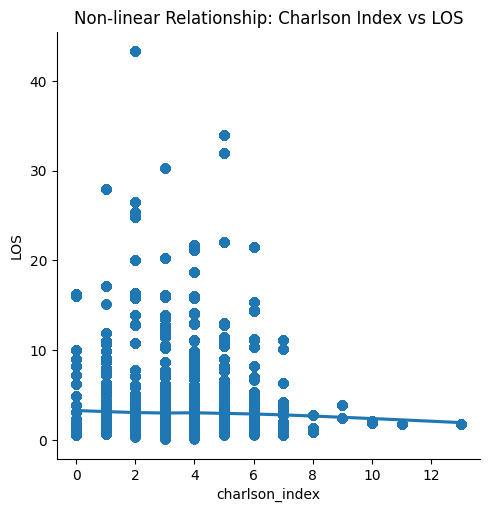

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x='charlson_index', y='LOS', data=dataset, lowess=True)
plt.title('Non-linear Relationship: Charlson Index vs LOS')
plt.show()


Most LOS values are concentrated between 0–10 days, across all index values. While some patients with lower Charlson scores (0–4) have long ICU stays (up to 40+ days), higher Charlson scores (above 6) are associated with consistently shorter ICU stays, which could reflect on:
* Higher mortality rates or earlier discharge decisions for patients with heavy comorbid burdens.
* Treatment limitations or palliative approaches in patients with poor prognosis.

We looked at the correlation table and decided that in our dataset to train the model we would only use variables that had a minimum correlation (in modulus) with our target variable LOS of 0.1.

### Choosing items to filter chartevents

Every chartevent corresponds to a measurament of an item.

In [44]:
dataset.ITEMID.nunique()

637

Preprocessing Items table. Needed because a lot of the same items are duplicated with different ITEMIDs. Example: heart rate

Useful for understanding how many distinct concepts there are, even if some are recorded by multiple ITEMIDs (e.g., heart rate via monitor and manually).

In [45]:
print(items[items['ITEMID'] == 211].LABEL)
print(items[items['ITEMID'] == 220045].LABEL)

print("\n")

print(len(items))
items['LABEL'].nunique()

475    Heart Rate
Name: LABEL, dtype: object
11498    Heart Rate
Name: LABEL, dtype: object


12487


11846

In [46]:
dataset = dataset.merge(items[["LABEL", "ITEMID"]], on="ITEMID", how="left")

To analyze heart rate availability and variation, we first standardize measurement labels to lowercase for consistency. We then count how many individual heart rate observations exist and how many unique ICU stays include at least one such measurement. Finally, we examine which ITEMIDs were used to record heart rate for each patient. This helps us understand whether different recording methods (e.g., manual vs. monitor) were used and confirms that both relevant ITEMIDs are contributing to heart rate data coverage across the cohort.

In [47]:
dataset['LABEL'] = dataset['LABEL'].str.lower()
print(len(dataset[dataset['LABEL'] == "heart rate"]))
print(dataset[dataset['LABEL'] == "heart rate"]["ICUSTAY_ID"].nunique())
result = dataset[dataset['LABEL'] == "heart rate"].groupby('SUBJECT_ID')['ITEMID'].unique()
result

19434
671


SUBJECT_ID
165      [220045.0]
176         [211.0]
177         [211.0]
199         [211.0]
205         [211.0]
            ...    
99893    [220045.0]
99901    [220045.0]
99938    [220045.0]
99944    [220045.0]
99982    [220045.0]
Name: ITEMID, Length: 524, dtype: object

To understand which clinical variables are most commonly recorded, we group the dataset by LABEL (the name of the measurement) and ITEMID (its corresponding identifier). For each combination, we count the number of unique ICU stays where the variable was observed. This allows us to measure how broadly each clinical variable is available across the patient population.

In [48]:
label_counts = dataset.groupby(['LABEL', 'ITEMID'])['ICUSTAY_ID'].nunique().reset_index(name='count')
label_counts = label_counts.sort_values(by='count', ascending=False)
print(label_counts.head(20))

                                       LABEL    ITEMID  count
150                               creatinine  220615.0    717
438                        potassium (serum)  227442.0    717
104                                      bun  225624.0    716
127                         chloride (serum)  220602.0    716
534                           sodium (serum)  220645.0    716
227                             hco3 (serum)  227443.0    716
223                          glucose (serum)  220621.0    711
238                       hematocrit (serum)  220545.0    710
34                                 anion gap  227073.0    710
633                                      wbc  220546.0    708
430                           platelet count  227457.0    708
242                               hemoglobin  220228.0    708
338                                magnesium  220635.0    695
424                              phosphorous  225677.0    654
111                      calcium non-ionized  225625.0    653
496     

Sorting the results in descending order to highlight the 20 most frequently recorded measurements helps to prioritise which variables are most suitable for inclusion in modelling and analysis based on their coverage. Common variables appear at the top, indicating that they are widely measured and thus reliable for building features across the dataset.

Together with external research we identified the the items that are most related with heart failure in order to increase length of stay. We also wanted the ones with sufficient counts of events relating to those items.

In [49]:
dataset = dataset[dataset["ITEMID"].isin([
    211, 220045, 51, 455, 6701, 6, 443, 220179, 618, 220210,
    223900, 226512, 227489, 646, 220277, 220739, 7294, 227446, 225622,
    1525, 220615, 227442, 225624, 220621
])]

label_counts = dataset.groupby('LABEL')['ICUSTAY_ID'].nunique().reset_index(name='count')
label_counts = label_counts.sort_values(by='count', ascending=False)
print(label_counts)

                                   LABEL  count
3                             creatinine    732
8                      potassium (serum)    717
2                                    bun    716
4                        glucose (serum)    711
5                             heart rate    671
9                       respiratory rate    671
7            o2 saturation pulseoxymetry    648
6   non invasive blood pressure systolic    602
0                  admission weight (kg)    554
1         brain natiuretic peptide (bnp)     68
10                                  spo2     22


In [50]:
# exclude the variable labeled "spo2"
dataset = dataset[dataset["LABEL"] != "spo2"]
label_counts = dataset.groupby('LABEL')['ICUSTAY_ID'].nunique().reset_index(name='count')
label_counts = label_counts.sort_values(by='count', ascending=False)
print(label_counts)

                                  LABEL  count
3                            creatinine    732
8                     potassium (serum)    717
2                                   bun    716
4                       glucose (serum)    711
5                            heart rate    671
9                      respiratory rate    671
7           o2 saturation pulseoxymetry    648
6  non invasive blood pressure systolic    602
0                 admission weight (kg)    554
1        brain natiuretic peptide (bnp)     68


We reconfirm that all clinical measurement values are numeric by explicitly converting the VALUE column using pd.to_numeric(). We verify that there are no missing values (NaN).

In [51]:
dataset["VALUE"] = pd.to_numeric(dataset["VALUE"])
print(dataset["VALUE"].isna().sum())

0


Ensuring that our dataset contains only complete records for modeling and analysis.

In [52]:
dataset = dataset.dropna(axis=0)

To prepare the dataset for modeling, we aggregate the clinical measurements for each ICU stay by computing the mean value of each variable. This simplifies time-series data into fixed-length numerical features.

We then pivot the dataset so that each clinical variable becomes a column and each row corresponds to a unique ICU stay. Finally, we merge these aggregated features back with the demographic and comorbidity data, ensuring that each ICU stay has one complete row with both static patient information and summarized clinical measurements. This flat, structured format is ideal for supervised machine learning or statistical analysis.

In [53]:
dataset_agg = dataset.groupby(['ICUSTAY_ID', 'LABEL'], as_index=False)['VALUE'].mean()

# Pivot the dataset to transform 'LABEL' into columns
pivoted = dataset_agg.pivot_table(index='ICUSTAY_ID', columns='LABEL', values='VALUE', aggfunc='mean').reset_index()

# Merge the pivoted dataset back with the original dataset, ensuring 'ICUSTAY_ID' stays unique
merged_dataset = dataset.drop(columns=['VALUE', 'LABEL'])  # Drop the 'VALUE' and 'LABEL' columns for the merge
pivoted_dataset = pd.merge(merged_dataset.drop_duplicates(subset=['ICUSTAY_ID']), pivoted, on='ICUSTAY_ID', how='left')

# Show the first 10 rows of the final dataset
pivoted_dataset.head(10)

,ICUSTAY_ID,SUBJECT_ID,HADM_ID,LOS,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,...,admission weight (kg),brain natiuretic peptide (bnp),bun,creatinine,glucose (serum),heart rate,non invasive blood pressure systolic,o2 saturation pulseoxymetry,potassium (serum),respiratory rate
0,224571,305,122211,0.7925,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,76.681818,NaN,NaN,NaN,13.863636
1,232248,305,122211,5.8118,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,75.228571,NaN,NaN,NaN,15.171429
2,249949,323,106158,4.4319,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,WIDOWED,WHITE,...,NaN,NaN,NaN,NaN,NaN,91.000000,NaN,NaN,NaN,22.444444
3,206073,323,128132,11.9999,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,WIDOWED,WHITE,...,NaN,NaN,NaN,NaN,NaN,84.382353,NaN,NaN,NaN,20.575758
4,281750,351,174800,3.8597,EMERGENCY,EMERGENCY ROOM ADMIT,Government,OTHER,UNKNOWN (DEFAULT),BLACK/AFRICAN AMERICAN,...,NaN,NaN,NaN,NaN,NaN,95.800000,NaN,NaN,NaN,19.333333
5,247247,165,170252,0.9628,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,OTHER,SINGLE,BLACK/AFRICAN AMERICAN,...,70.0,NaN,39.0,2.0,163.0,66.478261,131.217391,98.434783,4.4,17.478261
6,273927,176,135828,0.5142,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,JEWISH,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,70.250000,NaN,NaN,NaN,16.062500
7,231756,177,143120,9.0276,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,JEWISH,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,78.600000,NaN,NaN,NaN,20.400000
8,288571,177,143120,8.2186,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,JEWISH,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,85.857143,NaN,NaN,NaN,19.904762
9,255303,177,143120,9.9668,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,JEWISH,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,61.647059,NaN,NaN,NaN,18.333333


In [54]:
pivoted_dataset["brain natiuretic peptide (bnp)"] = pivoted_dataset["brain natiuretic peptide (bnp)"].notna()

After computing correlations we saw weight has almost 0 correlation to LOS, so we drop it since it would make us drop useful rows in the dropna().

In [55]:
pivoted_dataset = pivoted_dataset.drop(columns="admission weight (kg)")

Removes all rows from pivoted_dataset that contain any missing values (NaN).

In [56]:
pivoted_dataset = pivoted_dataset.dropna(axis=0)

In [57]:
print(len(pivoted_dataset))
pivoted_dataset.head()

587


,ICUSTAY_ID,SUBJECT_ID,HADM_ID,LOS,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,...,CHARLSON_IND_FINAL,brain natiuretic peptide (bnp),bun,creatinine,glucose (serum),heart rate,non invasive blood pressure systolic,o2 saturation pulseoxymetry,potassium (serum),respiratory rate
5,247247,165,170252,0.9628,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,OTHER,SINGLE,BLACK/AFRICAN AMERICAN,...,8,False,39.0,2.00,163.0,66.478261,131.217391,98.434783,4.400000,17.478261
16,241803,1354,144830,0.8186,EMERGENCY,PHYS REFERRAL/NORMAL DELI,Medicare,CATHOLIC,MARRIED,WHITE,...,4,False,72.5,1.85,108.5,80.100000,99.714286,96.105263,3.350000,19.800000
18,299666,422,117029,5.1139,EMERGENCY,EMERGENCY ROOM ADMIT,Private,CATHOLIC,MARRIED,WHITE,...,3,False,24.0,1.05,117.5,62.769231,103.916667,93.629630,4.066667,21.115385
25,244320,1578,168848,1.4416,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,JEWISH,SINGLE,WHITE,...,6,True,51.5,2.05,110.5,62.227273,118.181818,91.260870,4.833333,20.608696
26,239587,1578,144429,1.5444,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,JEWISH,SINGLE,WHITE,...,7,False,64.5,1.90,142.5,62.043478,112.750000,90.444444,4.250000,21.782609


In [58]:
pivoted_dataset.columns

Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'charlson_index', 'GENDER', 'comorbidity1_4254',
       'comorbidity1_42731', 'comorbidity1_486', 'comorbidity1_51881',
       'comorbidity1_5849', 'comorbidity2_4254', 'comorbidity2_4280',
       'comorbidity2_42731', 'comorbidity2_5849', 'comorbidity2_5990',
       'ITEMID', 'VALUENUM', 'VALUEUOM', 'DAYS_FROM_INTIME',
       'ETHNICITY_GROUPED', 'AGE', 'age_cat', 'CHARLSON_IND_FINAL',
       'brain natiuretic peptide (bnp)', 'bun', 'creatinine',
       'glucose (serum)', 'heart rate', 'non invasive blood pressure systolic',
       'o2 saturation pulseoxymetry', 'potassium (serum)', 'respiratory rate'],
      dtype='object')

We investigate the relationships between key clinical variables and ICU length of stay (LOS) by using Spearman correlation.

In [59]:
dtemp2 = pivoted_dataset.copy()

dtemp2 = dtemp2[['brain natiuretic peptide (bnp)', 'bun',
       'creatinine', 'glucose (serum)', 'heart rate',
       'non invasive blood pressure systolic', 'o2 saturation pulseoxymetry',
       'potassium (serum)', 'respiratory rate', 'LOS']]

corr = dtemp2.corr(method="spearman")
corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,brain natiuretic peptide (bnp),bun,creatinine,glucose (serum),heart rate,non invasive blood pressure systolic,o2 saturation pulseoxymetry,potassium (serum),respiratory rate,LOS
brain natiuretic peptide (bnp),1.000000,0.013756,-0.022041,0.004531,0.102215,0.012440,0.021453,0.044915,0.071440,0.066812
bun,0.013756,1.000000,0.724180,0.045507,-0.140663,-0.085165,0.008744,0.146503,-0.162687,0.253189
creatinine,-0.022041,0.724180,1.000000,-0.024865,-0.165740,0.035381,0.008033,0.190438,-0.176387,0.135600
glucose (serum),0.004531,0.045507,-0.024865,1.000000,0.089300,0.088321,0.026476,0.080593,0.138715,0.039201
heart rate,0.102215,-0.140663,-0.165740,0.089300,1.000000,-0.159126,-0.024495,0.148084,0.325138,0.126385
non invasive blood pressure systolic,0.012440,-0.085165,0.035381,0.088321,-0.159126,1.000000,-0.049071,-0.046406,0.128485,-0.263848
o2 saturation pulseoxymetry,0.021453,0.008744,0.008033,0.026476,-0.024495,-0.049071,1.000000,0.003299,-0.182741,-0.047587
potassium (serum),0.044915,0.146503,0.190438,0.080593,0.148084,-0.046406,0.003299,1.000000,0.030599,0.070375
respiratory rate,0.071440,-0.162687,-0.176387,0.138715,0.325138,0.128485,-0.182741,0.030599,1.000000,-0.007985
LOS,0.066812,0.253189,0.135600,0.039201,0.126385,-0.263848,-0.047587,0.070375,-0.007985,1.000000


To narrow the focus of our analysis, we select the clinical values that have a correlation (in modulus) above 0.1 with LOS.

In [60]:
pivoted_dataset = pivoted_dataset[["bun", "creatinine", "heart rate",
                  "non invasive blood pressure systolic", "ICUSTAY_ID"]]

To prepare a complete and analysis-ready dataset, we first remove duplicates from the static patient data (dtemp) to ensure one row per ICU stay. We then merge this information with the selected clinical features from pivoted_dataset, using ICUSTAY_ID as the unique key. The result is a flat dataset where each row corresponds to a single ICU stay and includes both clinical measurements and patient characteristics which is ideal for machine learning and regression analysis.

In [61]:
dtemp_unique = dtemp.drop_duplicates(subset=['ICUSTAY_ID'])
final_dataset = pivoted_dataset.merge(dtemp_unique, on=['ICUSTAY_ID'], how='left')

As the final dataset we select all the variables from the first and second correlation tables that have a minimum correlation (in modulus) of 0.1 with the target variable LOS.

In [62]:
final_dataset = final_dataset[[
    "comorbidity1_51881", "comorbidity1_5849", "comorbidity2_4280",
    "RELIGION_BUDDHIST", "ETHNICITY_GROUPED_White",
    "ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM", "GENDER_M",
    "bun", "creatinine", "heart rate", "non invasive blood pressure systolic",
    "LOS", "ICUSTAY_ID",
    "comorbidity1_4254", "RELIGION_BAPTIST", "comorbidity2_5990",
    "RELIGION_PROTESTANT QUAKER", "ETHNICITY_GROUPED_Black",
    "INSURANCE_Medicaid", "ETHNICITY_GROUPED_Other", "comorbidity2_5849",
    "ADMISSION_TYPE_ELECTIVE", "ETHNICITY_GROUPED_Asian",
    "RELIGION_JEWISH", "MARITAL_STATUS_MARRIED", "ADMISSION_TYPE_URGENT",
    "RELIGION_CHRISTIAN SCIENTIST", "MARITAL_STATUS_UNKNOWN (DEFAULT)",
    "comorbidity1_42731", "ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE",
    "ADMISSION_LOCATION_EMERGENCY ROOM ADMIT", "comorbidity2_42731",
    "INSURANCE_Self Pay", "RELIGION_EPISCOPALIAN", "RELIGION_JEHOVAH'S WITNESS",
    "ADMISSION_LOCATION_TRANSFER FROM OTHER HEALT", "comorbidity1_486",
    "ADMISSION_TYPE_EMERGENCY", "RELIGION_HINDU", "MARITAL_STATUS_WIDOWED",
    "RELIGION_MUSLIM", "MARITAL_STATUS_SINGLE", "ETHNICITY_GROUPED_Hispanic/Latino",
    "RELIGION_OTHER", "INSURANCE_Private", "RELIGION_GREEK ORTHODOX",
    "ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR", "RELIGION_CATHOLIC",
    "ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI", "RELIGION_ROMANIAN EAST. ORTH",
    "INSURANCE_Government", "INSURANCE_Medicare"
]]

In [63]:
print(final_dataset.columns)
print(len(final_dataset))
final_dataset.head()

Index(['comorbidity1_51881', 'comorbidity1_5849', 'comorbidity2_4280',
       'RELIGION_BUDDHIST', 'ETHNICITY_GROUPED_White',
       'ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM', 'GENDER_M', 'bun',
       'creatinine', 'heart rate', 'non invasive blood pressure systolic',
       'LOS', 'ICUSTAY_ID', 'comorbidity1_4254', 'RELIGION_BAPTIST',
       'comorbidity2_5990', 'RELIGION_PROTESTANT QUAKER',
       'ETHNICITY_GROUPED_Black', 'INSURANCE_Medicaid',
       'ETHNICITY_GROUPED_Other', 'comorbidity2_5849',
       'ADMISSION_TYPE_ELECTIVE', 'ETHNICITY_GROUPED_Asian', 'RELIGION_JEWISH',
       'MARITAL_STATUS_MARRIED', 'ADMISSION_TYPE_URGENT',
       'RELIGION_CHRISTIAN SCIENTIST', 'MARITAL_STATUS_UNKNOWN (DEFAULT)',
       'comorbidity1_42731', 'ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE',
       'ADMISSION_LOCATION_EMERGENCY ROOM ADMIT', 'comorbidity2_42731',
       'INSURANCE_Self Pay', 'RELIGION_EPISCOPALIAN',
       'RELIGION_JEHOVAH'S WITNESS',
       'ADMISSION_LOCATION_TRANSFE

,comorbidity1_51881,comorbidity1_5849,comorbidity2_4280,RELIGION_BUDDHIST,ETHNICITY_GROUPED_White,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,GENDER_M,bun,creatinine,heart rate,...,ETHNICITY_GROUPED_Hispanic/Latino,RELIGION_OTHER,INSURANCE_Private,RELIGION_GREEK ORTHODOX,ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR,RELIGION_CATHOLIC,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,RELIGION_ROMANIAN EAST. ORTH,INSURANCE_Government,INSURANCE_Medicare
0,True,False,False,False,False,False,True,39.0,2.00,66.478261,...,False,True,False,False,False,False,False,False,False,True
1,False,True,False,False,True,False,True,72.5,1.85,80.100000,...,False,False,False,False,False,True,True,False,False,True
2,True,False,False,False,True,False,True,24.0,1.05,62.769231,...,False,False,True,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,51.5,2.05,62.227273,...,False,False,False,False,False,False,False,False,False,True
4,True,False,False,False,True,False,False,64.5,1.90,62.043478,...,False,False,False,False,False,False,False,False,False,True


In [64]:
pd.set_option('display.max_columns', None)  
final_dataset.describe(include= 'all')

,comorbidity1_51881,comorbidity1_5849,comorbidity2_4280,RELIGION_BUDDHIST,ETHNICITY_GROUPED_White,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,GENDER_M,bun,creatinine,heart rate,non invasive blood pressure systolic,LOS,ICUSTAY_ID,comorbidity1_4254,RELIGION_BAPTIST,comorbidity2_5990,RELIGION_PROTESTANT QUAKER,ETHNICITY_GROUPED_Black,INSURANCE_Medicaid,ETHNICITY_GROUPED_Other,comorbidity2_5849,ADMISSION_TYPE_ELECTIVE,ETHNICITY_GROUPED_Asian,RELIGION_JEWISH,MARITAL_STATUS_MARRIED,ADMISSION_TYPE_URGENT,RELIGION_CHRISTIAN SCIENTIST,MARITAL_STATUS_UNKNOWN (DEFAULT),comorbidity1_42731,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,comorbidity2_42731,INSURANCE_Self Pay,RELIGION_EPISCOPALIAN,RELIGION_JEHOVAH'S WITNESS,ADMISSION_LOCATION_TRANSFER FROM OTHER HEALT,comorbidity1_486,ADMISSION_TYPE_EMERGENCY,RELIGION_HINDU,MARITAL_STATUS_WIDOWED,RELIGION_MUSLIM,MARITAL_STATUS_SINGLE,ETHNICITY_GROUPED_Hispanic/Latino,RELIGION_OTHER,INSURANCE_Private,RELIGION_GREEK ORTHODOX,ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR,RELIGION_CATHOLIC,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,RELIGION_ROMANIAN EAST. ORTH,INSURANCE_Government,INSURANCE_Medicare
count,587,587,587,587,587,587,587,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587,587
unique,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
freq,509,444,552,584,426,499,317,NaN,NaN,NaN,NaN,NaN,NaN,565,587,562,494,493,549,556,536,563,577,487,334,578,583,578,585,336,399,578,584,583,586,586,532,554,586,460,582,438,561,452,500,578,584,357,531,585,578,450
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.183563,2.124459,82.112015,115.804242,3.895124,249636.732538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.208541,1.597898,15.235311,26.766664,4.327413,28174.988075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.333333,0.466667,49.000000,73.750000,0.143700,200350.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.666667,1.166667,70.881410,100.835796,1.277750,225140.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.500000,1.600000,80.692308,111.441176,2.515200,248825.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.000000,2.500000,91.629167,127.136513,4.377300,274172.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


More than 500 cases of false we get rid of the column

In [65]:
final_dataset = final_dataset.drop(columns=['comorbidity1_51881','comorbidity2_4280','RELIGION_BUDDHIST','comorbidity1_4254','RELIGION_BAPTIST','comorbidity2_5990','INSURANCE_Medicaid','ETHNICITY_GROUPED_Other',
                            'comorbidity2_5849','ADMISSION_TYPE_ELECTIVE','ETHNICITY_GROUPED_Asian','ADMISSION_TYPE_URGENT','RELIGION_CHRISTIAN SCIENTIST','MARITAL_STATUS_UNKNOWN (DEFAULT)','comorbidity1_42731','comorbidity2_42731',
                            'INSURANCE_Self Pay','RELIGION_EPISCOPALIAN',"RELIGION_JEHOVAH'S WITNESS",'ADMISSION_LOCATION_TRANSFER FROM OTHER HEALT','comorbidity1_486','ADMISSION_TYPE_EMERGENCY',
                            'RELIGION_HINDU','RELIGION_MUSLIM','ETHNICITY_GROUPED_Hispanic/Latino','RELIGION_GREEK ORTHODOX','ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR','ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI','RELIGION_ROMANIAN EAST. ORTH','INSURANCE_Government'])

In [66]:
final_dataset.head(2)

,comorbidity1_5849,ETHNICITY_GROUPED_White,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,GENDER_M,bun,creatinine,heart rate,non invasive blood pressure systolic,LOS,ICUSTAY_ID,RELIGION_PROTESTANT QUAKER,ETHNICITY_GROUPED_Black,RELIGION_JEWISH,MARITAL_STATUS_MARRIED,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,MARITAL_STATUS_WIDOWED,MARITAL_STATUS_SINGLE,RELIGION_OTHER,INSURANCE_Private,RELIGION_CATHOLIC,INSURANCE_Medicare
0,False,False,False,True,39.0,2.00,66.478261,131.217391,0.9628,247247,False,True,False,False,True,False,False,True,True,False,False,True
1,True,True,False,True,72.5,1.85,80.100000,99.714286,0.8186,241803,False,False,False,True,False,False,False,False,False,False,True,True


### Scaling

We define a function to standardize continuous features in our dataset using z-score normalization (mean = 0, std = 1), which helps ensure that features are on the same scale and suitable for modeling. Binary features and the target variable LOS are excluded from scaling to preserve their interpretability and structure. This step helps many machine learning models converge faster and perform better.

In [67]:
def scaling(df):
    scaler = preprocessing.StandardScaler()

    no_change = [col for col in df.columns if set(df[col].unique()) == {0, 1} or col == 'LOS'] 
    continuous_cols = [col for col in df.columns if col not in no_change]

    df_scaled = df.copy()
    df_scaled[continuous_cols] = scaler.fit_transform(df[continuous_cols])
    
    return df_scaled

### Final Preparation for modeling 

To prepare the dataset for machine learning, we start by removing the ICU stay identifier, as it holds no predictive value. We then converted any remaining boolean fields into binary numeric format (1/0) and infer appropriate data types to ensure compatibility with machine learning models Afterward, we apply z-score normalization to standardize all continuous features, while preserving binary variables and the target LOS. We then split it into features (X) and the target variable (y, ICU Length of Stay) and use an 80/20 split to separate the data into a training set (used to train the model) and a test set (used to evaluate its performance on unseen data).

In [68]:
final_dataset2 = final_dataset.copy()

final_dataset2 = final_dataset2.drop(columns=['ICUSTAY_ID'])

warnings.filterwarnings('ignore')
final_dataset2 = final_dataset2.replace({True: 1, False: 0}).infer_objects(copy=False)

X = final_dataset2.drop(columns=['LOS'])
y = final_dataset2['LOS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaling(X_train)
X_test_scaled = scaling(X_test)

rftrain =  X_train_scaled
elastic_test = X_test_scaled

print(f'Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}')

Train: (469, 20), Test: (118, 20)


## Training and Validation

### Evaluation

To evaluate our regression model’s performance in predicting ICU length of stay, we define a function that reports key error metrics: MAE, MSE, RMSE, R², and MAPE. These metrics provide a comprehensive view of both the average error and the model’s explanatory power. 

In addition to numerical scores, we visualize the predictions:
* A line plot compares actual vs. predicted LOS, sorted by true values, making it easy to assess where the model aligns or diverges from reality.
* A residual bar plot helps detect systematic under or overfitting, guiding error analysis and potential model refinement.

This function provides both quantitative and visual feedback, making it a robust tool for interpreting model effectiveness.

In [69]:
def evaluation(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print(f"MAPE: {mape*100:.2f}%")

    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    sorted_idx = np.argsort(y_test)[::-1]

    y_test_sorted = y_test[sorted_idx]
    y_pred_sorted = y_pred[sorted_idx]
    residuals = y_test_sorted - y_pred_sorted

    plt.figure(figsize=(8, 3))
    plt.plot(y_test_sorted, label='Actual LOS', marker='o')
    plt.plot(y_pred_sorted, label='Predicted LOS', marker='x')
    plt.title('Actual vs Predicted LOS (sorted by Actual LOS - descending)')
    plt.xlabel('Sample index (sorted)')
    plt.ylabel('Length of Stay (LOS)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 3))
    plt.bar(range(len(residuals)), residuals, color='orange')
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Residuals (Actual LOS − Predicted LOS)')
    plt.xlabel('Sample index (sorted by Actual LOS)')
    plt.ylabel('Residual (error)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

### Baseline Model - Dummy Regressor

To establish a performance baseline, we use a DummyRegressor that always predicts the average length of stay from the training data. This model serves as a simple benchmark, allowing us to measure how much value a more sophisticated model adds. By comparing future models against this baseline, we can confirm whether our approach is meaningfully learning from the data or not.

MAE: 2.83
MSE: 15.58
RMSE: 3.95
R²: -0.01
MAPE: 132.87%


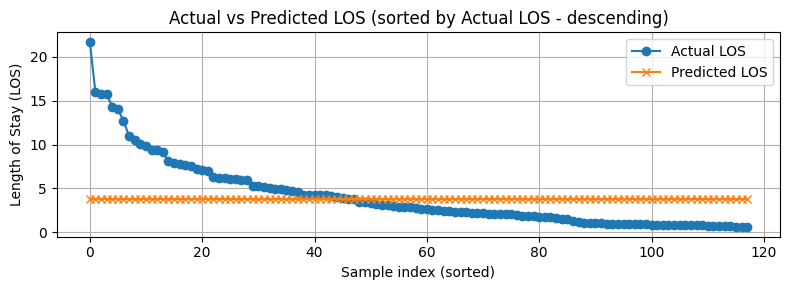

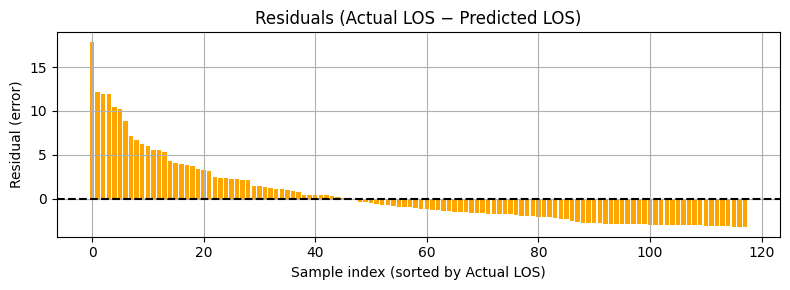

<Figure size 640x480 with 0 Axes>

In [70]:
dummy = DummyRegressor(strategy='mean') 
dummy.fit(X_train_scaled, y_train)

y_pred = dummy.predict(X_test_scaled)

evaluation(y_test, y_pred)

To compare multiple regression algorithms for predicting ICU length of stay, we define a grid of models with their respective hyperparameters. For each model, we perform a grid search with 5-fold cross-validation using RMSE as the scoring metric. This ensures that we select the best hyperparameters in a fair and consistent way.

After identifying the best configuration, we evaluate each model on the test set using our custom evaluation function. This provides not only error metrics like MAE and RMSE but also visual diagnostics of prediction accuracy and residuals. This thorough process helps us identify which model performs best and where each model may succeed or fail in predicting ICU LOS.

--- Linear Regression ---
Best params: {}
MAE: 2.51
MSE: 13.60
RMSE: 3.69
R²: 0.12
MAPE: 106.55%


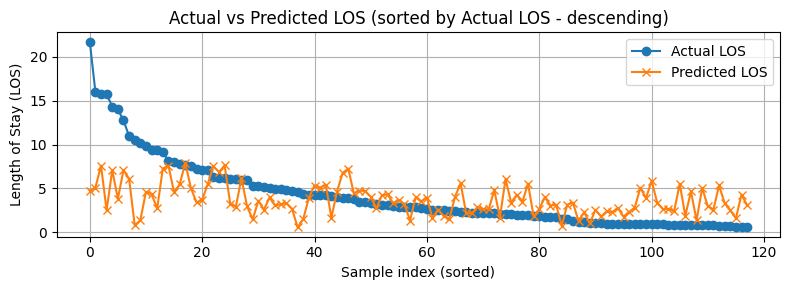

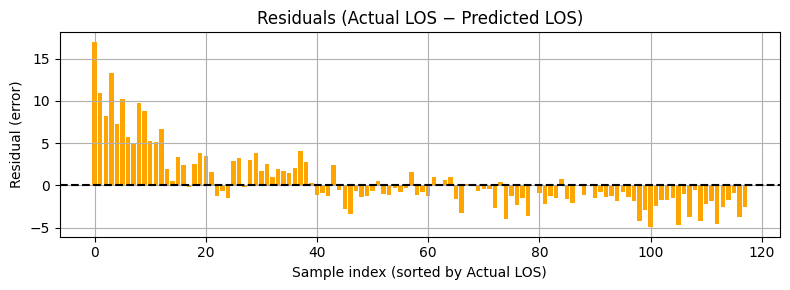

<Figure size 640x480 with 0 Axes>



--- Ridge Regression ---
Best params: {'alpha': 100, 'solver': 'auto'}
MAE: 2.50
MSE: 13.40
RMSE: 3.66
R²: 0.14
MAPE: 111.05%


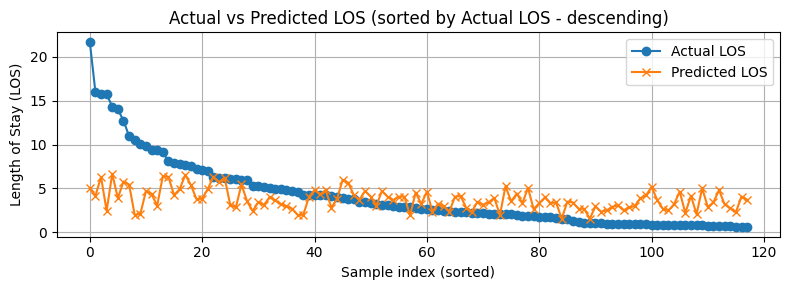

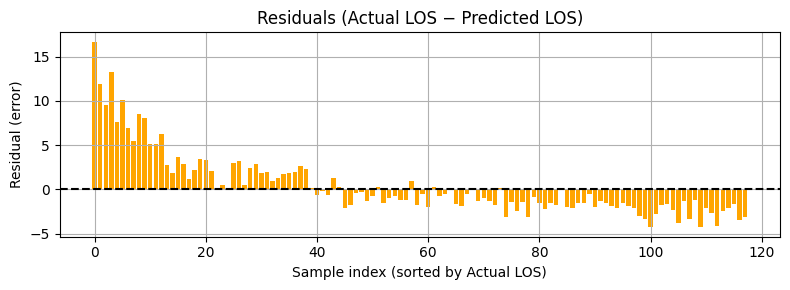

<Figure size 640x480 with 0 Axes>



--- Lasso Regression ---
Best params: {'alpha': 0.1, 'max_iter': 1000}
MAE: 2.51
MSE: 13.43
RMSE: 3.66
R²: 0.13
MAPE: 111.46%


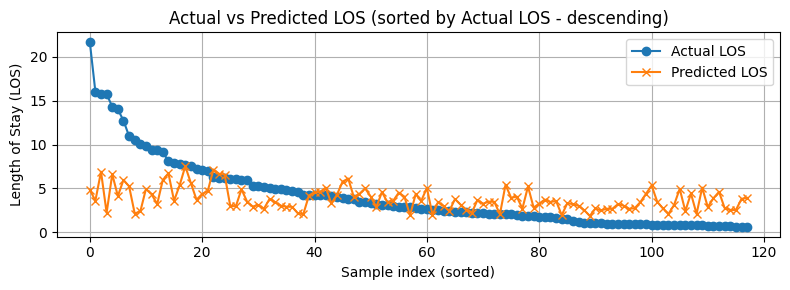

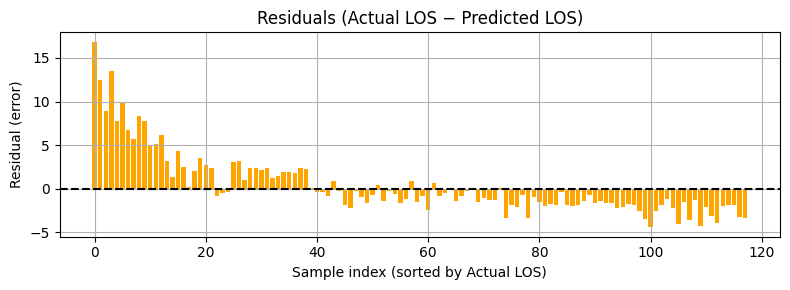

<Figure size 640x480 with 0 Axes>



--- ElasticNet Regression ---
Best params: {'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 1000}
MAE: 2.49
MSE: 13.32
RMSE: 3.65
R²: 0.14
MAPE: 108.53%


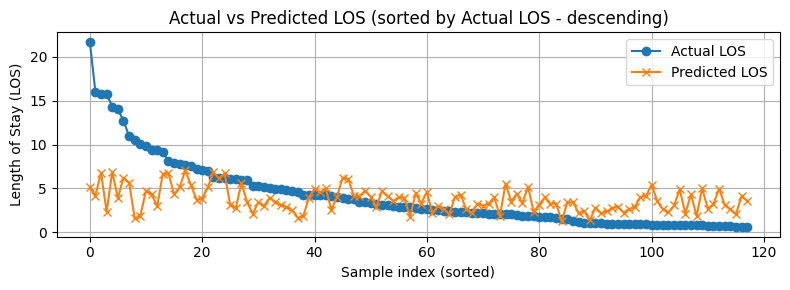

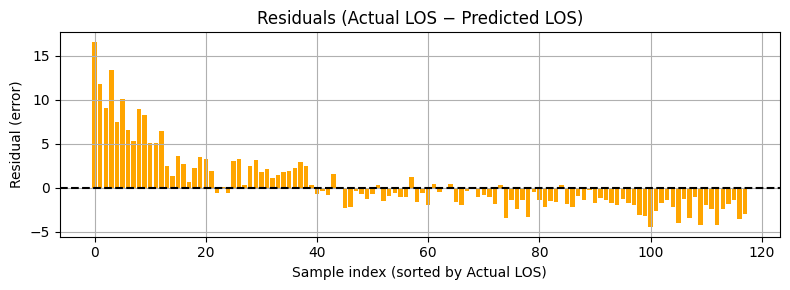

<Figure size 640x480 with 0 Axes>



--- Decision Tree Regressor ---
Best params: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
MAE: 3.13
MSE: 20.17
RMSE: 4.49
R²: -0.30
MAPE: 124.84%


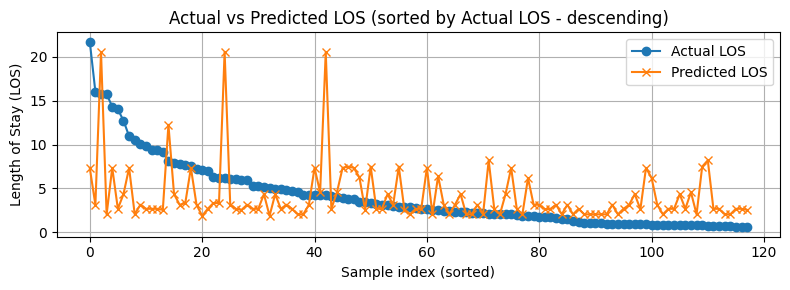

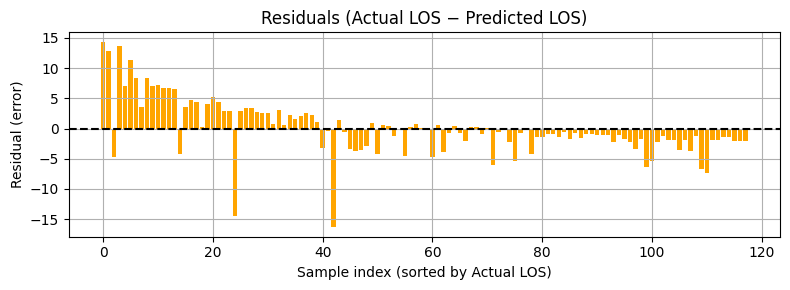

<Figure size 640x480 with 0 Axes>



--- Random Forest Regressor ---
Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
MAE: 2.71
MSE: 15.24
RMSE: 3.90
R²: 0.02
MAPE: 118.83%


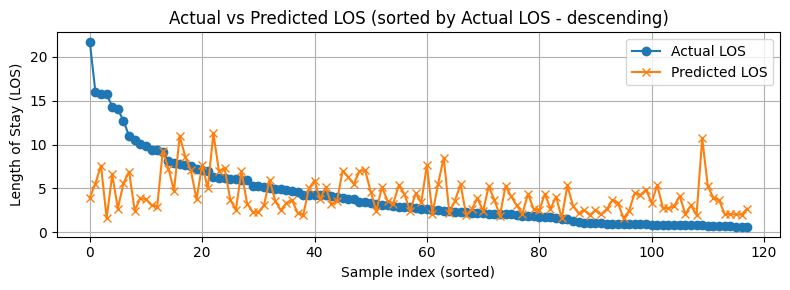

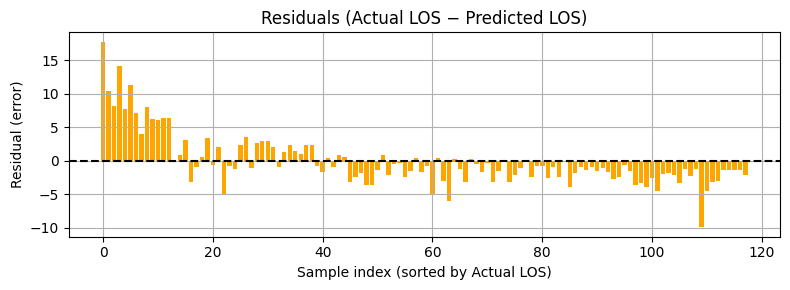

<Figure size 640x480 with 0 Axes>



--- Gradient Boosting Regressor ---
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
MAE: 2.75
MSE: 15.41
RMSE: 3.93
R²: 0.01
MAPE: 126.40%


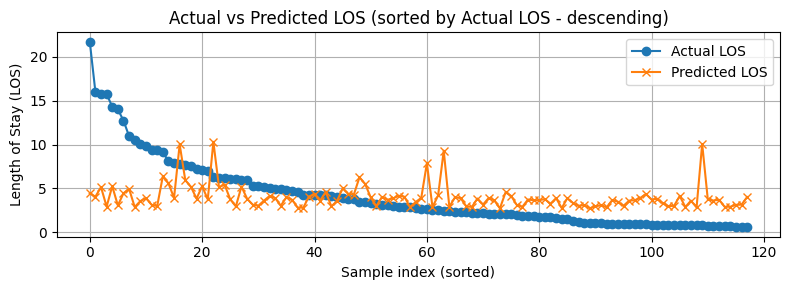

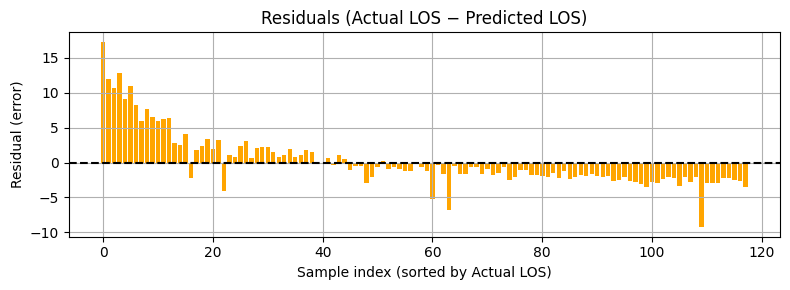

<Figure size 640x480 with 0 Axes>



--- KNN Regressor ---
Best params: {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
MAE: 2.65
MSE: 14.73
RMSE: 3.84
R²: 0.05
MAPE: 118.49%


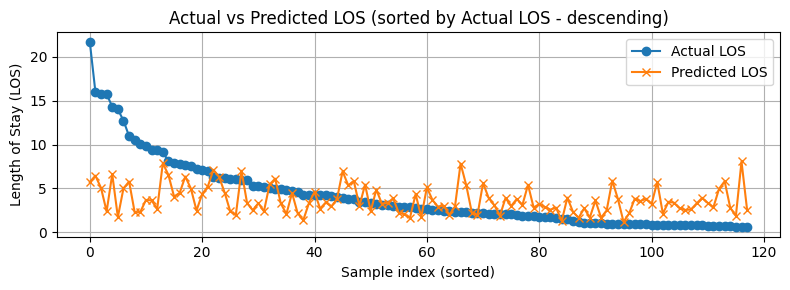

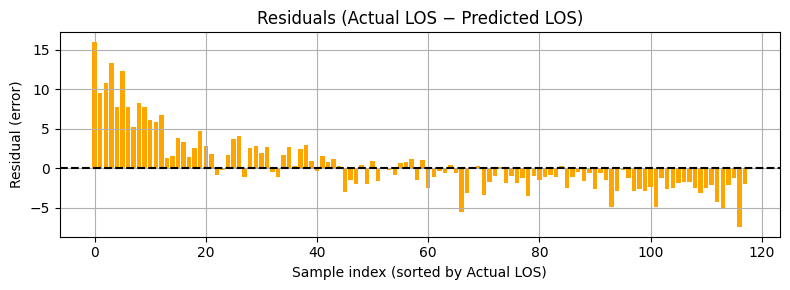

<Figure size 640x480 with 0 Axes>



--- SVR (Support Vector Regression) ---
Best params: {'C': 0.1, 'epsilon': 1, 'kernel': 'linear'}
MAE: 2.50
MSE: 15.66
RMSE: 3.96
R²: -0.01
MAPE: 83.84%


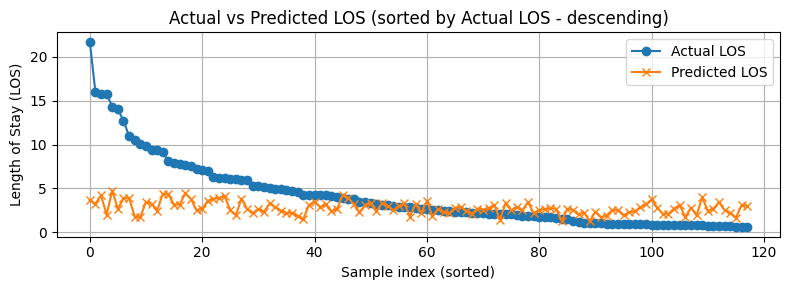

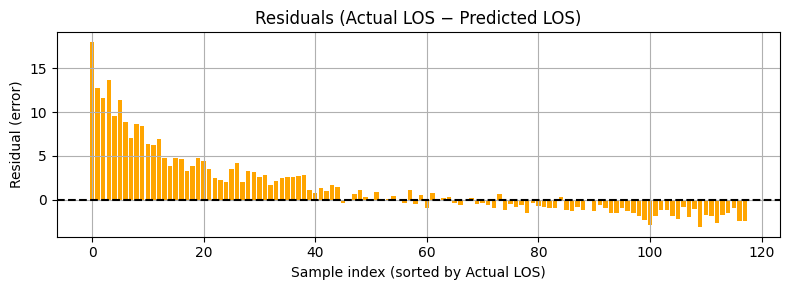

<Figure size 640x480 with 0 Axes>



--- XGBoost Regressor ---
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
MAE: 2.59
MSE: 14.42
RMSE: 3.80
R²: 0.07
MAPE: 113.63%


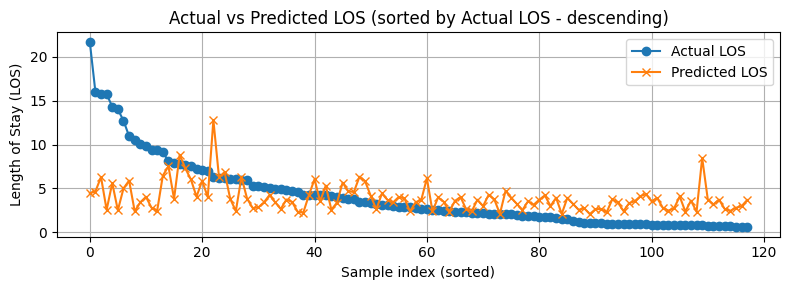

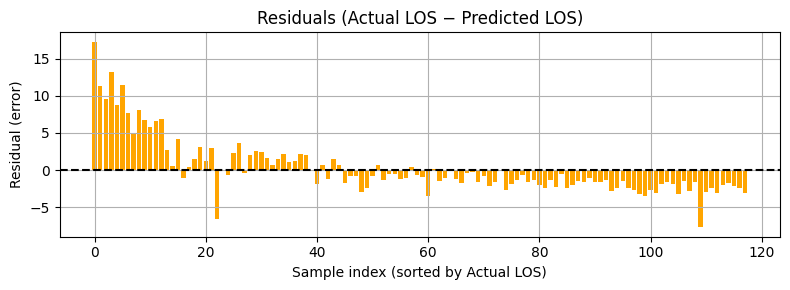

<Figure size 640x480 with 0 Axes>



--- Huber Regressor ---
Best params: {'alpha': 0.01, 'epsilon': 1.5, 'max_iter': 100}
MAE: 2.47
MSE: 15.08
RMSE: 3.88
R²: 0.03
MAPE: 84.96%


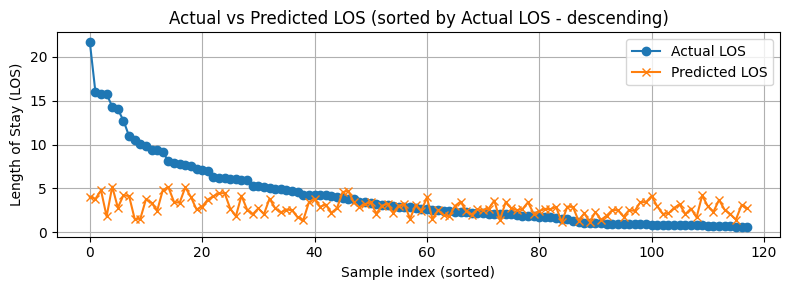

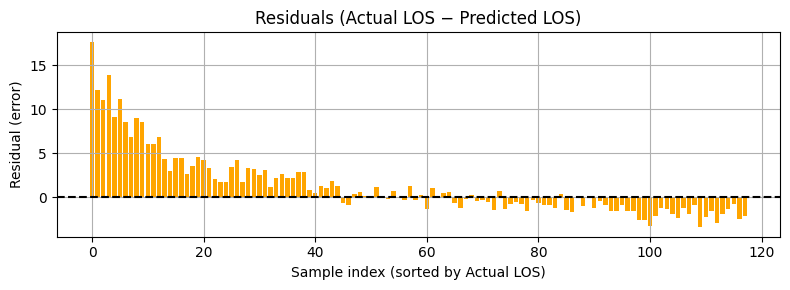

<Figure size 640x480 with 0 Axes>

In [71]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

sample_weight = np.where(y_train > 6, 2.0, 1.0)

param_grids = {
    'Linear Regression': ({}, LinearRegression()),

    'Ridge Regression': ({
        'alpha': [0.01, 0.1, 1, 10, 100],
        'solver': ['auto', 'saga', 'lbfgs']
    }, Ridge()),

    'Lasso Regression': ({
        'alpha': [0.001, 0.01, 0.1, 1],
        'max_iter': [1000, 5000]
    }, Lasso()),

    'ElasticNet Regression': ({
        'alpha': [0.001, 0.01, 0.1, 1],
        'l1_ratio': [0.1, 0.5, 0.9],
        'max_iter': [1000, 5000]
    }, ElasticNet()),

    'Decision Tree Regressor': ({
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }, DecisionTreeRegressor(random_state=42)),

    'Random Forest Regressor': ({
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }, RandomForestRegressor(random_state=42)),

    'Gradient Boosting Regressor': ({
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    }, GradientBoostingRegressor(random_state=42)),

    'KNN Regressor': ({
        'n_neighbors': range(1, 11),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  
    }, KNeighborsRegressor()),

    'SVR (Support Vector Regression)': ({
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 1],
        'kernel': ['linear', 'rbf']
    }, SVR()),

    'XGBoost Regressor': ({
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }, XGBRegressor(random_state=42)),

    'Huber Regressor': ({
        'epsilon': [1.2, 1.35, 1.5],
        'alpha': [0.0001, 0.001, 0.01],
        'max_iter': [100, 500]
    }, HuberRegressor())
}

for name, (param_grid, model) in param_grids.items():
    print(f"--- {name} ---")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scorer,
        cv=kf,
        n_jobs=-1
    )
    """ 
    if name in ['SVR (Support Vector Regression)', 'KNN Regressor']:
        grid_search.fit(X_train_scaled, y_train)
    else:
        grid_search.fit(X_train_scaled, y_train, sample_weight=sample_weight) 
    """
    grid_search.fit(X_train_scaled, y_train)

    print("Best params:", grid_search.best_params_)

    y_pred = grid_search.best_estimator_.predict(X_test_scaled)
    evaluation(y_test, y_pred)

    print("\n")

Overall best: 

--- ElasticNet Regression ---

After evaluating multiple regression algorithms, we selected the ElasticNet Regression as the final model for predicting ICU Length of Stay (LOS). This choice reflects a balance between predictive performance, generalization capability, and robustness to noisy clinical data.

In [72]:
# Treinamento e predição com GridSearch
param_grids = {
    'ElasticNet Regression': ({
        'alpha': [0.001, 0.01, 0.1, 1],
        'l1_ratio': [0.1, 0.5, 0.9],
        'max_iter': [1000, 5000]
    }, ElasticNet()),
}

for name, (param_grid, model) in param_grids.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scorer,
        cv=kf,
        n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train)
    y_pred = grid_search.best_estimator_.predict(X_test_scaled)

    # Calcula erros absolutos
    errors = np.abs(y_test - y_pred)

    # Índices dos 5 melhores (menores erros)
    best_idxs = np.argsort(errors)[:5]
    # Índices dos 5 piores (maiores erros)
    worst_idxs = np.argsort(errors)[-5:]

    # Índices originais no DataFrame
    original_best_indices = y_test.iloc[best_idxs].index
    original_worst_indices = y_test.iloc[worst_idxs].index

    print("Original indices (best predictions):", original_best_indices.tolist())
    print("Original indices (worst predictions):", original_worst_indices.tolist())

    print("\n=== BEST 5 ICU STAYS ===")
    for idx in original_best_indices:
        icu_id = final_dataset.loc[idx, 'ICUSTAY_ID']
        subject_id = icustays.loc[icustays['ICUSTAY_ID'] == icu_id, 'SUBJECT_ID'].values[0]
        los = icustays.loc[icustays['ICUSTAY_ID'] == icu_id, 'LOS'].values[0]
        print(f"ICU_STAY: {icu_id}, SUBJECT_ID: {subject_id}, LOS: {los}")

    print("\n=== WORST 5 ICU STAYS ===")
    for idx in original_worst_indices:
        icu_id = final_dataset.loc[idx, 'ICUSTAY_ID']
        subject_id = icustays.loc[icustays['ICUSTAY_ID'] == icu_id, 'SUBJECT_ID'].values[0]
        los = icustays.loc[icustays['ICUSTAY_ID'] == icu_id, 'LOS'].values[0]
        print(f"ICU_STAY: {icu_id}, SUBJECT_ID: {subject_id}, LOS: {los}")

elastic_estimator = grid_search.best_estimator_

Original indices (best predictions): [548, 83, 360, 10, 90]
Original indices (worst predictions): [574, 331, 55, 264, 527]

=== BEST 5 ICU STAYS ===
ICU_STAY: 221067, SUBJECT_ID: 99944, LOS: 4.0542
ICU_STAY: 214913, SUBJECT_ID: 22432, LOS: 2.2313
ICU_STAY: 294684, SUBJECT_ID: 83565, LOS: 6.1733
ICU_STAY: 253415, SUBJECT_ID: 2338, LOS: 2.4773
ICU_STAY: 217086, SUBJECT_ID: 26398, LOS: 4.2218

=== WORST 5 ICU STAYS ===
ICU_STAY: 204903, SUBJECT_ID: 99067, LOS: 15.8199
ICU_STAY: 242289, SUBJECT_ID: 56527, LOS: 14.0159
ICU_STAY: 242739, SUBJECT_ID: 15054, LOS: 16.0222
ICU_STAY: 255074, SUBJECT_ID: 59507, LOS: 15.7452
ICU_STAY: 227524, SUBJECT_ID: 90142, LOS: 21.7437


### Comparing measures in the first day for both

In [85]:
def plot_top5_best_worst(best_ids, worst_ids, chartevents, icu_title="ICU"):

    colors = {
        'Heart Rate': 'lightskyblue',
        'BUN': 'hotpink',
        'Non-Invasive BP Systolic': 'lightgreen'
    }

    itemids = {
        'Heart Rate': 220045,
        'BUN': 225624,
        'Non-Invasive BP Systolic': 220179
    }

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(5, 2, figsize=(20, 40), sharey=True)
    axes = axes.flatten()

    all_ids = best_ids + worst_ids
    titles = [f"One of the Top 5 Best\n{icu_title}_{icu_id}" for icu_id in best_ids] + \
             [f"One of the Top 5 Worst\n{icu_title}_{icu_id}" for icu_id in worst_ids]

    for i, (icu_id, ax) in enumerate(zip(all_ids, axes)):
        for name, itemid in itemids.items():
            data = chartevents[(chartevents['ICUSTAY_ID'] == icu_id) &
                               (chartevents['ITEMID'] == itemid)][['DAYS_FROM_INTIME', 'VALUE']].copy()

            if not data.empty:
                data = data.sort_values('DAYS_FROM_INTIME')
                data['VALUE'] = pd.to_numeric(data['VALUE'], errors='coerce')
                data['DAYS_FROM_INTIME'] = pd.to_numeric(data['DAYS_FROM_INTIME'], errors='coerce')

                sns.scatterplot(data=data, x='DAYS_FROM_INTIME', y='VALUE',
                                color=colors[name], label=name, ax=ax)
                sns.regplot(data=data, x='DAYS_FROM_INTIME', y='VALUE',
                            scatter=False, lowess=True, ci=95,
                            color=colors[name], ax=ax)

        ax.set_title(titles[i])
        ax.set_xlabel("Time")
        ax.set_ylabel("Value" if i % 2 == 0 else "")

        # REMOVE essa linha, a menos que você tenha um motivo clínico real
        # ax.invert_yaxis()

        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), title="Measurement", loc='upper right', fontsize='small')

    plt.tight_layout()
    plt.show()

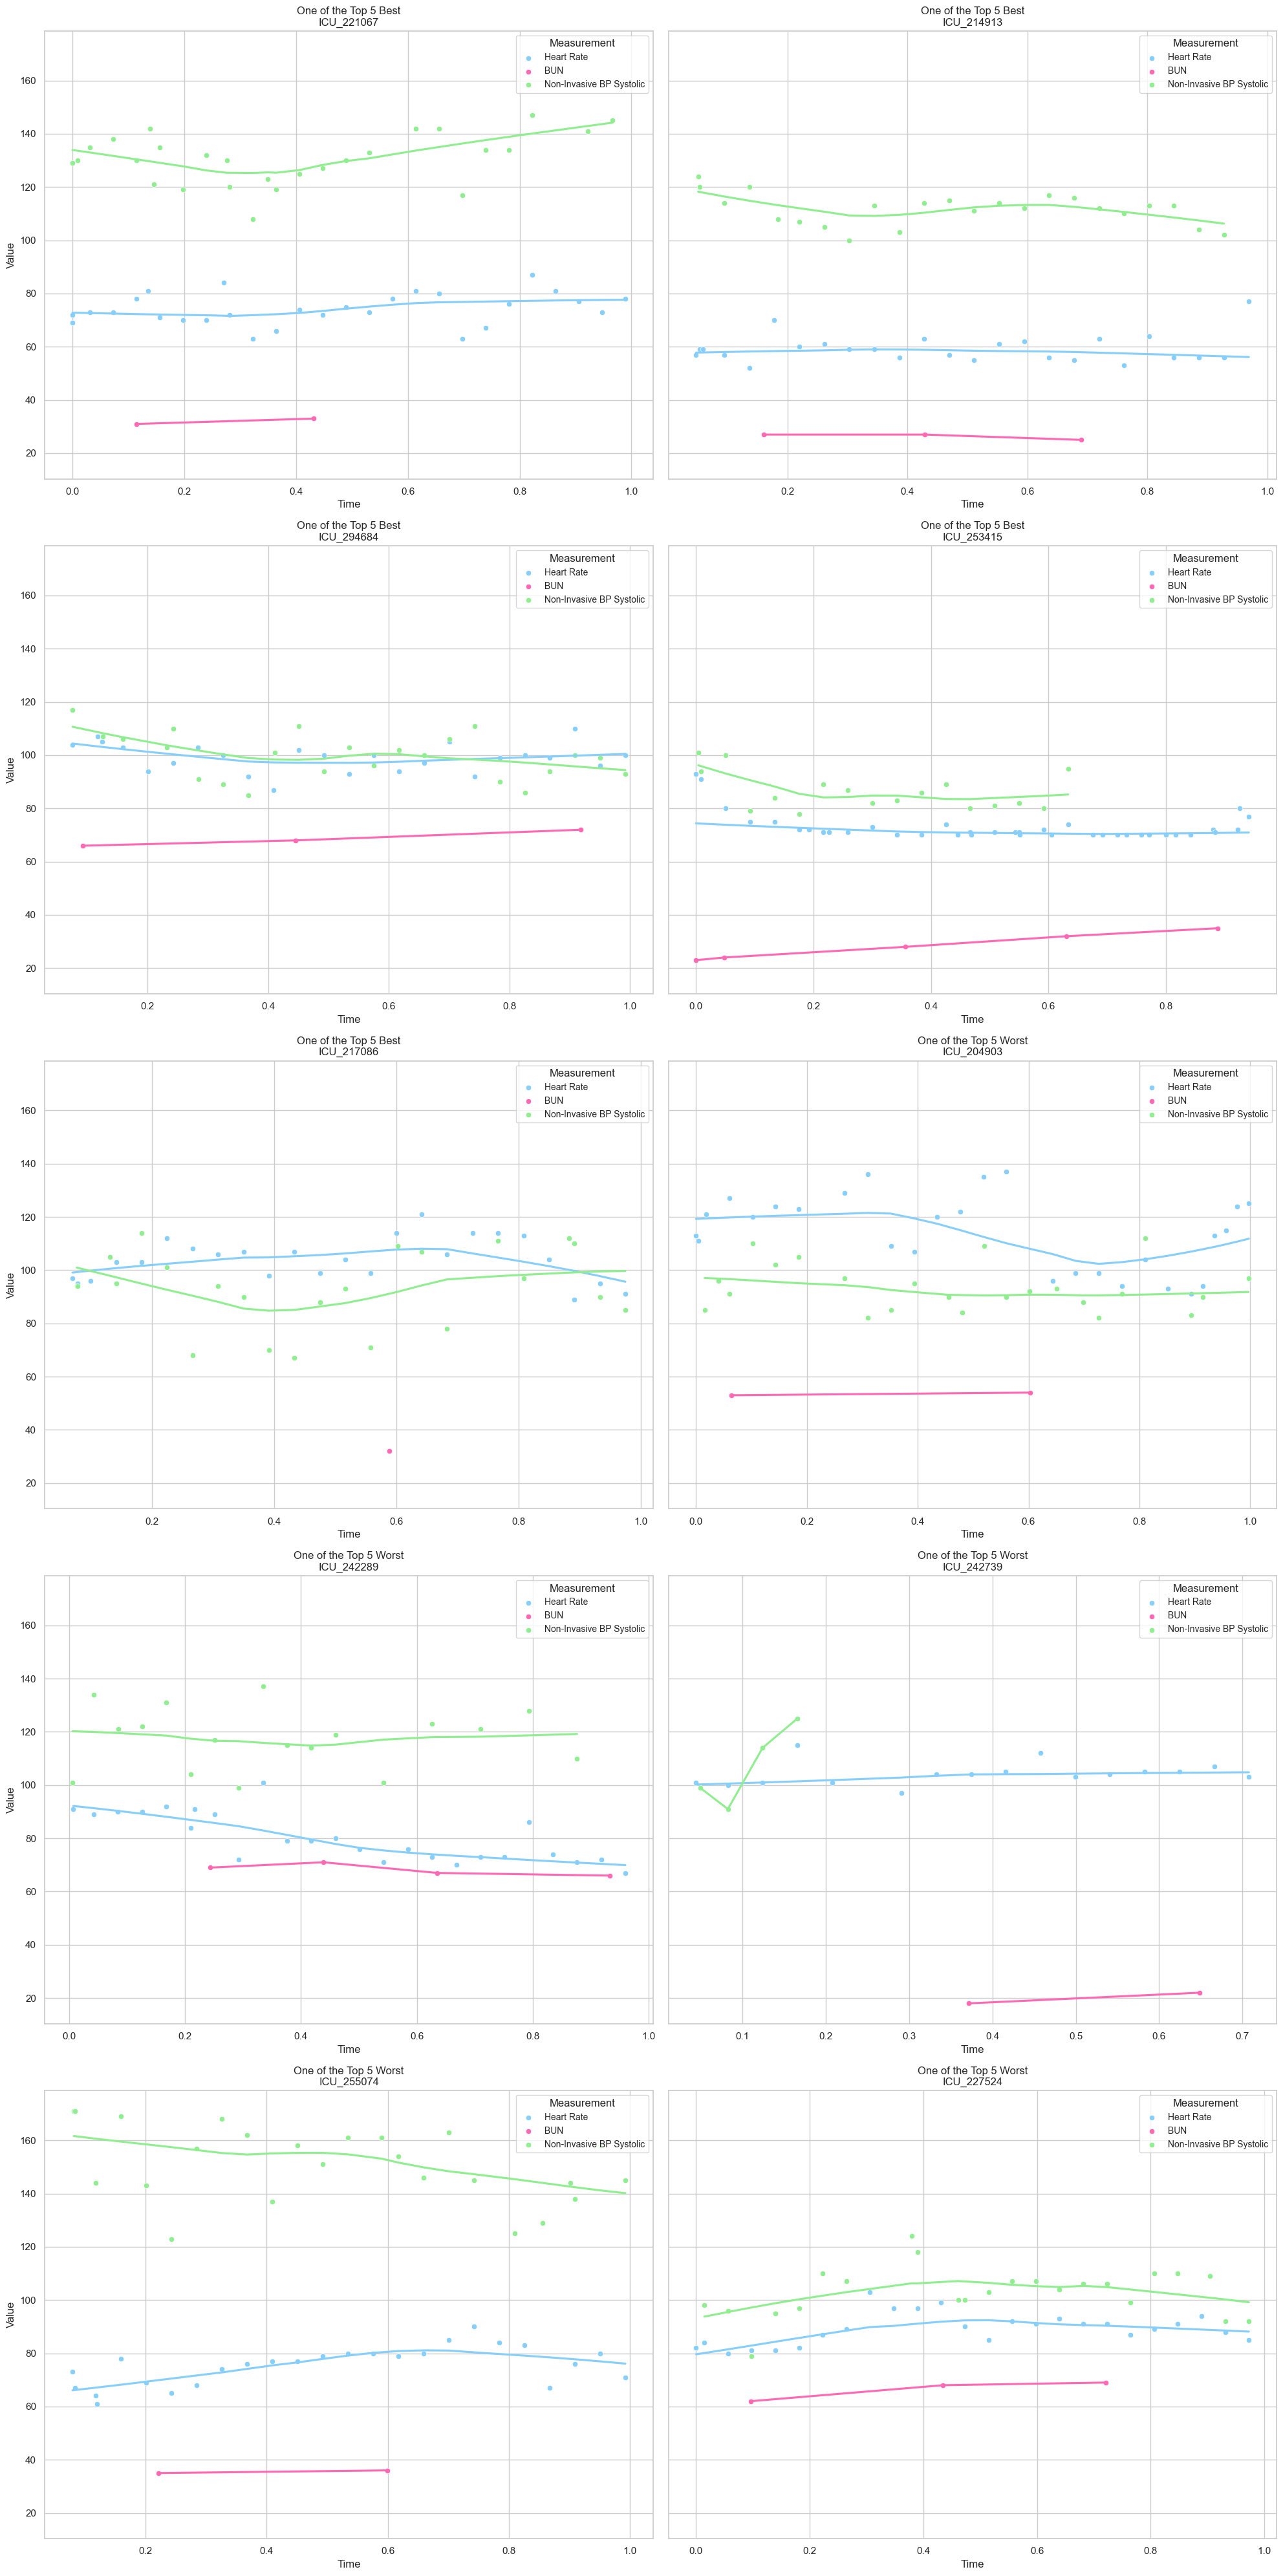

In [86]:
best_icu_ids = [221067,214913,294684,253415,217086]
worst_icu_ids = [204903,242289,242739,255074,227524]

plot_top5_best_worst(best_icu_ids, worst_icu_ids, chartevents_first_day)

## Interpreting Model Predictions with SHAP

To complement the visual analysis of the best and worst ICU predictions, we use SHAP (SHapley Additive Explanations) to interpret how the Random Forest Regressor made its predictions.

We analyze one best and one worst prediction in detail, identifying which clinical features pushed the predicted Length of Stay up or down. This allows us to validate whether the model relied on medically relevant patterns or missed key signals.


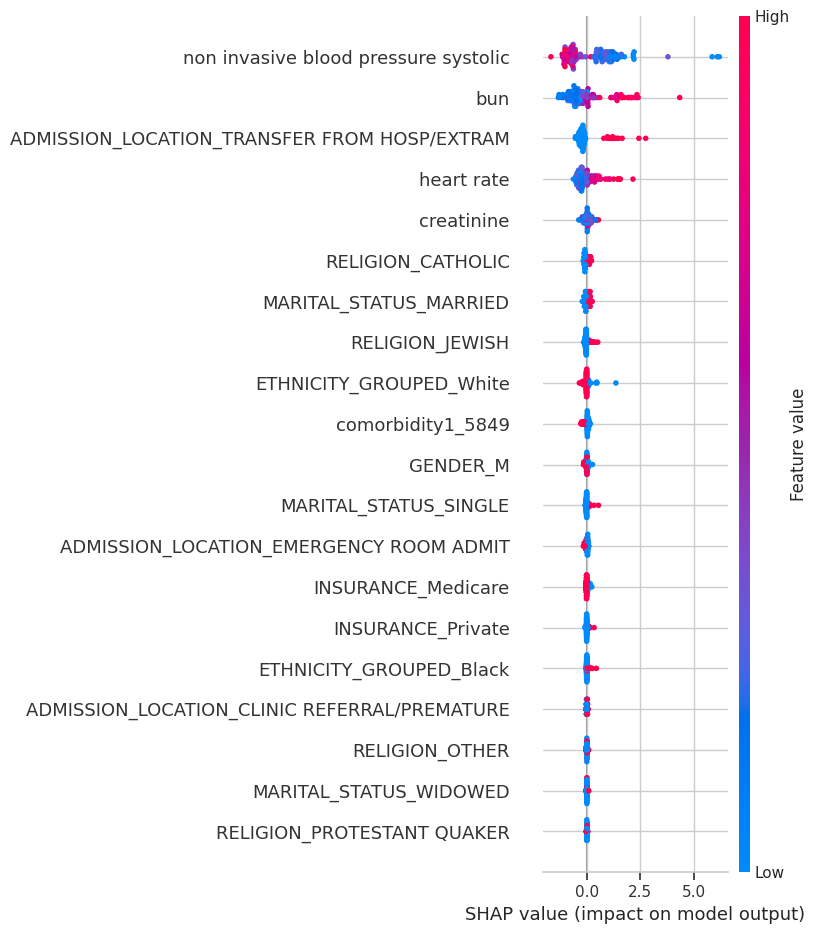

SHAP Explanation for a Best Prediction:


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not

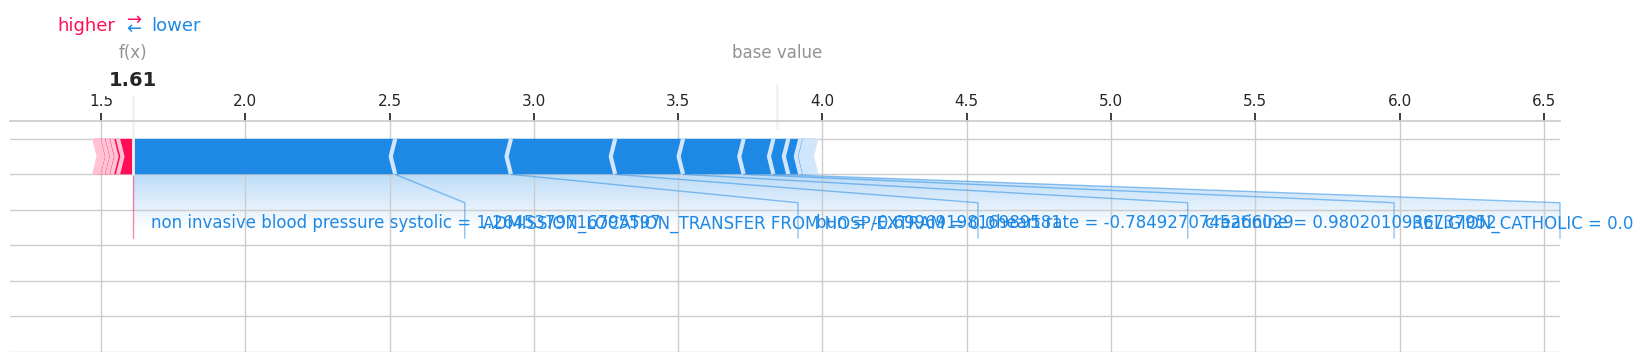

SHAP Explanation for a Worst Prediction:


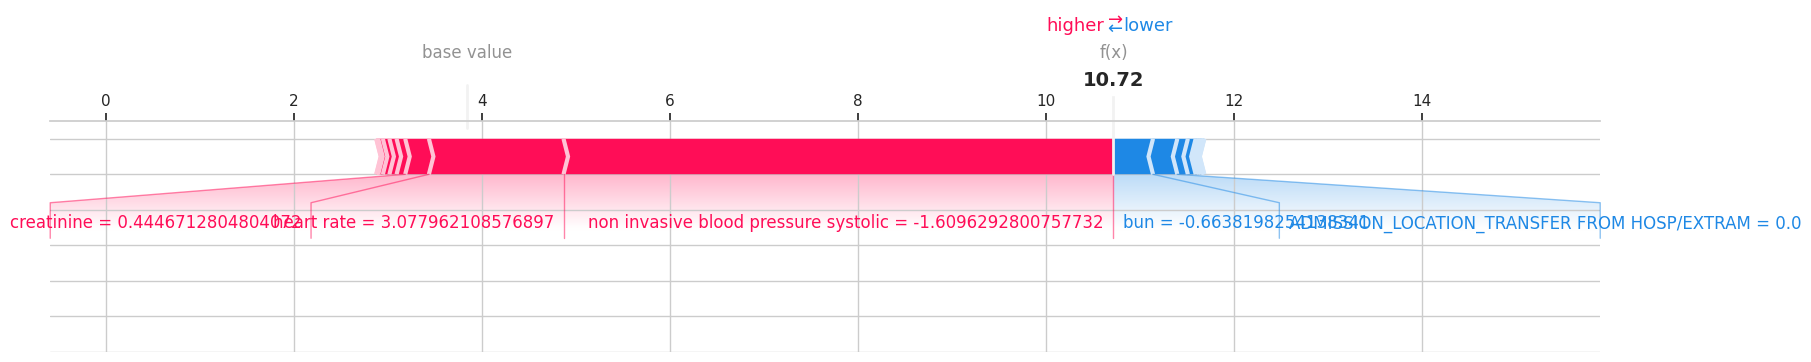

In [ ]:
# Initialize SHAP
shap.initjs()

# Create SHAP explainer for the best Random Forest model
explainer = shap.TreeExplainer(elastic_estimator)

X_test= rftest 

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# --- 1. Global Explanation: SHAP Summary Plot ---
# This shows the most important features across all patients
shap.summary_plot(shap_values, X_test)

# --- 2. Local Explanation: Best Prediction ---

# Select the first best prediction index from your earlier evaluation
best_index = original_best_indices[0]

# Extract the patient data and SHAP values for that prediction
best_patient = X_test.loc[best_index]
best_shap_values = explainer.shap_values(best_patient)

# Plot the SHAP force plot for this best-case prediction
print("SHAP Explanation for a Best Prediction:")
shap.force_plot(
    explainer.expected_value,
    best_shap_values,
    best_patient,
    matplotlib=True
)

# --- 3. Local Explanation: Worst Prediction ---

# Select the first worst prediction index from your earlier evaluation
worst_index = original_worst_indices[0]

# Extract the patient data and SHAP values for that prediction
worst_patient = X_test.loc[worst_index]
worst_shap_values = explainer.shap_values(worst_patient)

# Plot the SHAP force plot for this worst-case prediction
print("SHAP Explanation for a Worst Prediction:")
shap.force_plot(
    explainer.expected_value,
    worst_shap_values,
    worst_patient,
    matplotlib=True
)

#### SHAP Summary Plot (Global Feature Importance)

The summary plot ranks features based on their average impact on the model’s predictions for ICU Length of Stay (LOS). Key insights:

- **Non-invasive systolic blood pressure**, **BUN**, and **admission location** are the most influential predictors overall.
- **Low blood pressure** (blue) tends to push predictions **upward** (longer LOS), while **higher values** push predictions downward — consistent with clinical expectations.
- **Elevated BUN** and **creatinine** also contribute to longer LOS, likely indicating renal dysfunction.
- Comorbidities and demographic variables (e.g., ethnicity and gender) have a smaller but measurable impact.

#### SHAP Explanation: Best Prediction

For the selected **best-case prediction**, the model predicted an LOS of **1.55 days**, close to the true value.

- Most features in this case pushed the prediction **downward** (blue), such as:
  - **Non-invasive systolic BP**: relatively high, suggesting patient stability.
  - **Normal admission source** and **lack of severe comorbidities** also contributed to the shorter LOS prediction.
- This shows that the model recognized a relatively low-risk profile and responded appropriately.

#### SHAP Explanation: Worst Prediction

For the **worst-case prediction**, the model predicted **7.44 days**, which was significantly off.

- Features that pushed the prediction **upward** (red):
  - **High BUN** and **heart rate**, indicating possible physiological instability.
  - **Transfer admission source** and **certain demographics (e.g., White ethnicity)** also influenced the estimate.
- While some of these factors are valid indicators of higher risk, the model **overestimated** in this case — suggesting it may overweigh certain feature combinations under specific conditions.

#### Why This Matters

By using SHAP:
- We confirmed that the model is relying on clinically meaningful signals like **blood pressure**, **kidney function**, and **heart rate**.
- We can **investigate mispredictions**, understand their causes, and build trust in the model's reasoning — especially in critical care applications.

This interpretability step transforms our model from a black box into a transparent decision support tool.


The SHAP summary plot highlights that the most important features influencing ICU Length of Stay are physiologic and acute clinical markers, such as systolic blood pressure, BUN, and creatinine. These findings align with clinical intuition, as patients with abnormal vital signs or kidney dysfunction typically require longer ICU management. Admission source also plays a key role, suggesting that system-level factors contribute to LOS variation. Less influential but still relevant variables include specific comorbidities and demographics. Overall, the SHAP analysis confirms that the model is learning meaningful patterns and provides both transparency and clinical insight.

This helps you confirm that your model is behaving medically appropriately, and not relying on irrelevant or misleading patterns.

## Classification

To try a classification approach, we created a binary column called LOS_6, which flags ICU stays of more than six days. Greater than 6 is consireded a prolonged lenght of stay for people with HF in the United States (Tashtish, Nour et al.) ([source](https://onlinejcf.com/article/S1071-9164(17)30385-8/fulltext)), where the MIMIC-III data is from. However, the results were 490 for patients who stayed less than 6 days and 90 otherwise, which is very imbalanced, so we used resampling techniques.

In [77]:
def evaluation2(y, y_pred):
    # Classification Report
    print("Classification Report:\n", classification_report(y, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y, y_pred),
                annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [78]:
final_dataset3 = final_dataset2.copy()

final_dataset2['LOS_category'] = pd.cut(final_dataset2['LOS'], bins=[-1,2,6,100], labels=['short', 'medium', 'long'])

print(final_dataset2.columns)
final_dataset2["LOS_category"].value_counts()

final_dataset2 = final_dataset2.drop(columns=['LOS'])

Index(['comorbidity1_5849', 'ETHNICITY_GROUPED_White',
       'ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM', 'GENDER_M', 'bun',
       'creatinine', 'heart rate', 'non invasive blood pressure systolic',
       'LOS', 'RELIGION_PROTESTANT QUAKER', 'ETHNICITY_GROUPED_Black',
       'RELIGION_JEWISH', 'MARITAL_STATUS_MARRIED',
       'ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE',
       'ADMISSION_LOCATION_EMERGENCY ROOM ADMIT', 'MARITAL_STATUS_WIDOWED',
       'MARITAL_STATUS_SINGLE', 'RELIGION_OTHER', 'INSURANCE_Private',
       'RELIGION_CATHOLIC', 'INSURANCE_Medicare', 'LOS_category'],
      dtype='object')


In [79]:
X = final_dataset2.drop(columns=['LOS_category'])
y = final_dataset2['LOS_category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

--- Decision Tree Classifier ---
Best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.21      0.18        19
           1       0.48      0.43      0.46        53
           2       0.52      0.50      0.51        46

    accuracy                           0.42       118
   macro avg       0.39      0.38      0.38       118
weighted avg       0.44      0.42      0.43       118



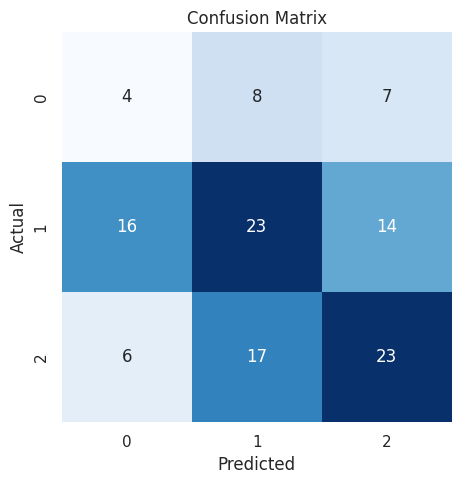



--- Random Forest Classifier ---
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.32      0.31        19
           1       0.47      0.40      0.43        53
           2       0.47      0.54      0.51        46

    accuracy                           0.44       118
   macro avg       0.41      0.42      0.41       118
weighted avg       0.44      0.44      0.44       118



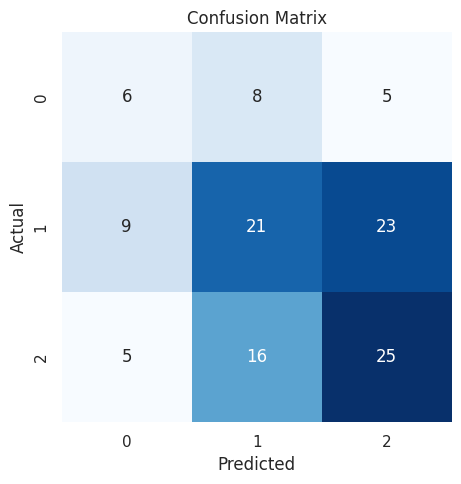



--- KNN Classifier ---
Best params: {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.26      0.21        19
           1       0.33      0.28      0.30        53
           2       0.39      0.37      0.38        46

    accuracy                           0.31       118
   macro avg       0.30      0.31      0.30       118
weighted avg       0.33      0.31      0.32       118



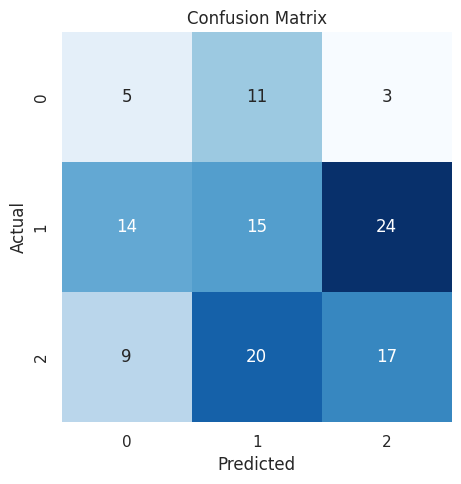



--- SVM (Support Vector Classification) ---
Best params: {'C': 10, 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.26      0.24        19
           1       0.43      0.38      0.40        53
           2       0.41      0.43      0.42        46

    accuracy                           0.38       118
   macro avg       0.35      0.36      0.35       118
weighted avg       0.39      0.38      0.38       118



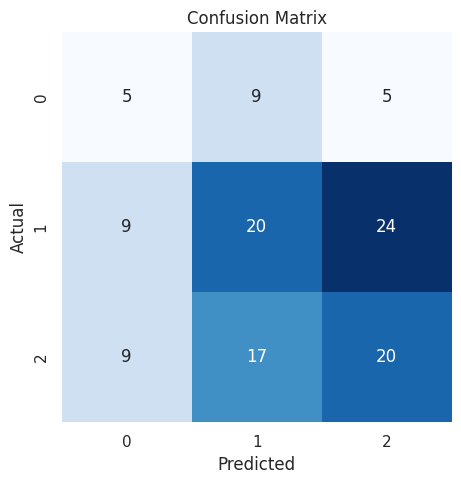



--- XGBoost Classifier ---
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.26      0.26        19
           1       0.42      0.40      0.41        53
           2       0.47      0.50      0.48        46

    accuracy                           0.42       118
   macro avg       0.38      0.39      0.39       118
weighted avg       0.41      0.42      0.41       118



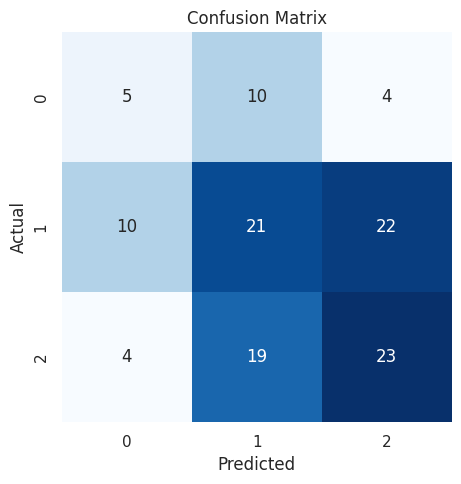

In [80]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scorer = make_scorer(accuracy_score)

param_grids = {

    'Decision Tree Classifier': ({
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }, DecisionTreeClassifier(random_state=42)),

    'Random Forest Classifier': ({
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }, RandomForestClassifier(random_state=42)),

    'KNN Classifier': ({
        'n_neighbors': range(1, 11),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  
    }, KNeighborsClassifier()),

    'SVM (Support Vector Classification)': ({
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }, SVC()),

    'XGBoost Classifier': ({
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }, XGBClassifier(random_state=42)),
}

for name, (param_grid, model) in param_grids.items():
    print(f"--- {name} ---")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=accuracy_scorer,
        cv=kf,
        n_jobs=-1
    )
    """ 
    if name in ['SVR (Support Vector Regression)', 'KNN Regressor']:
        grid_search.fit(X_train_scaled, y_train)
    else:
        grid_search.fit(X_train_scaled, y_train, sample_weight=sample_weight) 
    """
    grid_search.fit(X_train_scaled, y_train)

    print("Best params:", grid_search.best_params_)

    y_pred = grid_search.best_estimator_.predict(X_test_scaled)
    evaluation2(y_test, y_pred)

    print("\n")

### Classification with only >6 and <6 days of LOS

In [81]:
def evaluation3(y,y_pred):
    # Scores
    print("classification report: \n", classification_report(y,y_pred))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
    # Confusion Matrix
    sns.heatmap(confusion_matrix(y, y_pred), 
            annot=True, fmt="d", cmap="Blues", cbar=False, square=True, ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    auc_score = roc_auc_score(y, y_pred)

    axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", color="blue")
    axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
    axes[1].set_title("Receiver Operating Characteristic (ROC) Curve")
    axes[1].set_xlabel("False Positive Rate (FPR)")
    axes[1].set_ylabel("True Positive Rate (TPR)")
    axes[1].legend(loc="lower right")
    axes[1].grid()

    plt.tight_layout()
    plt.show()

In [82]:
final_dataset3['LOS_category'] = pd.cut(
    final_dataset3['LOS'],
    bins=[-1, 6, 100],
    labels=[0, 1]
).astype(int)

print(final_dataset3["LOS_category"].value_counts())

final_dataset3 = final_dataset3.drop(columns=['LOS'])

print(final_dataset3.columns)

LOS_category
0    493
1     94
Name: count, dtype: int64
Index(['comorbidity1_5849', 'ETHNICITY_GROUPED_White',
       'ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM', 'GENDER_M', 'bun',
       'creatinine', 'heart rate', 'non invasive blood pressure systolic',
       'RELIGION_PROTESTANT QUAKER', 'ETHNICITY_GROUPED_Black',
       'RELIGION_JEWISH', 'MARITAL_STATUS_MARRIED',
       'ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE',
       'ADMISSION_LOCATION_EMERGENCY ROOM ADMIT', 'MARITAL_STATUS_WIDOWED',
       'MARITAL_STATUS_SINGLE', 'RELIGION_OTHER', 'INSURANCE_Private',
       'RELIGION_CATHOLIC', 'INSURANCE_Medicare', 'LOS_category'],
      dtype='object')


In [83]:
X = final_dataset3.drop(columns=['LOS_category'])
y = final_dataset3['LOS_category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

--- Decision Tree Classifier ---


Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
classification report: 
               precision    recall  f1-score   support

           0       0.85      0.71      0.77        99
           1       0.19      0.37      0.25        19

    accuracy                           0.65       118
   macro avg       0.52      0.54      0.51       118
weighted avg       0.75      0.65      0.69       118



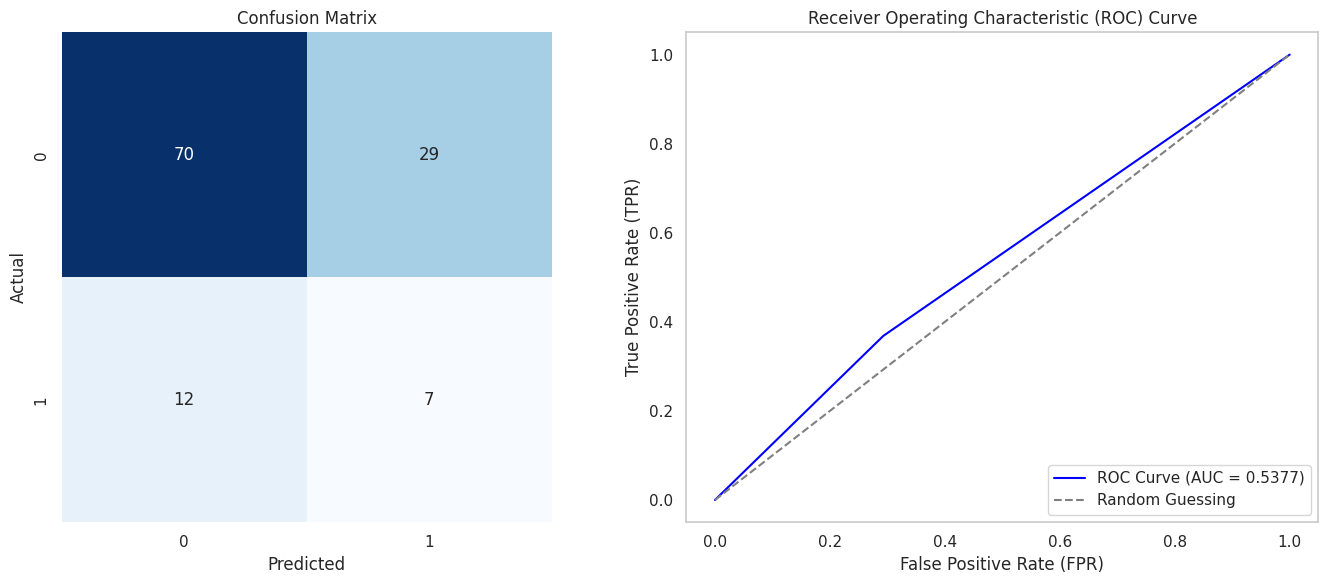



--- Random Forest Classifier ---
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
classification report: 
               precision    recall  f1-score   support

           0       0.85      0.87      0.86        99
           1       0.24      0.21      0.22        19

    accuracy                           0.76       118
   macro avg       0.54      0.54      0.54       118
weighted avg       0.75      0.76      0.76       118



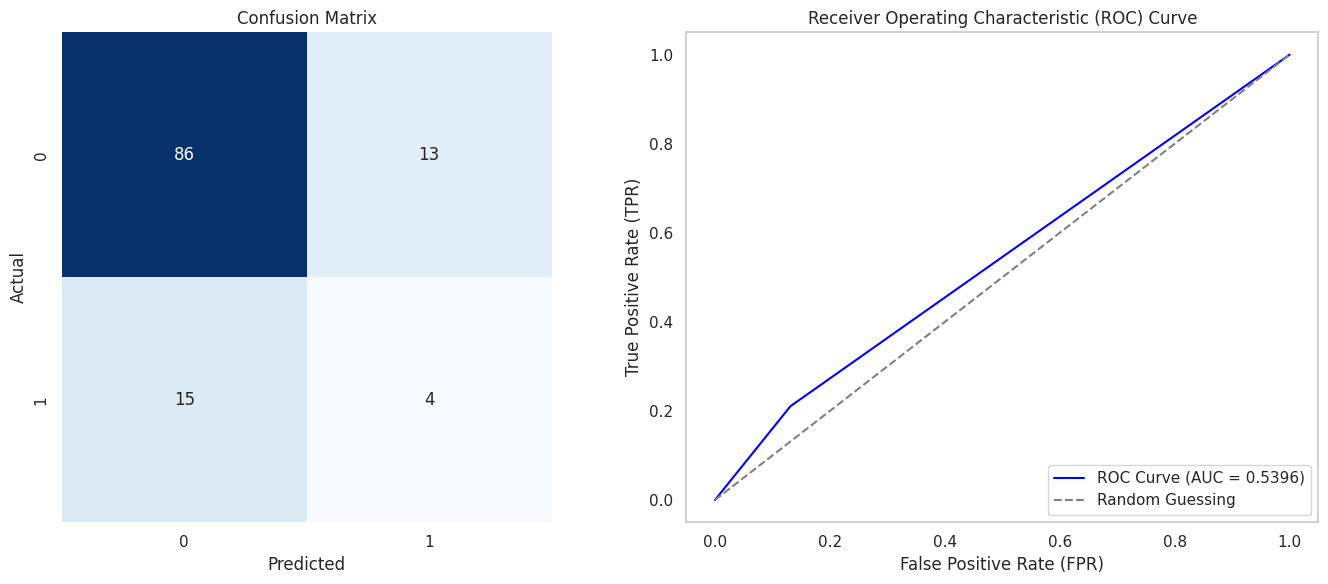



--- KNN Classifier ---
Best params: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
classification report: 
               precision    recall  f1-score   support

           0       0.84      0.77      0.80        99
           1       0.18      0.26      0.21        19

    accuracy                           0.69       118
   macro avg       0.51      0.52      0.51       118
weighted avg       0.74      0.69      0.71       118



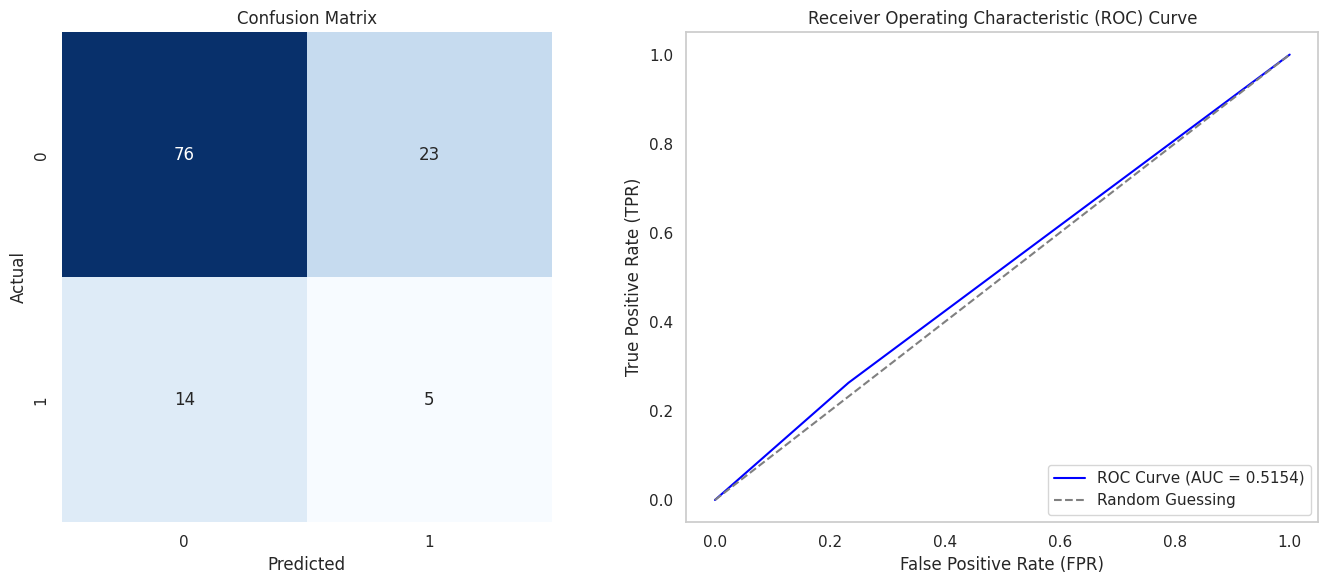



--- SVM (Support Vector Classification) ---
Best params: {'C': 10, 'kernel': 'rbf'}
classification report: 
               precision    recall  f1-score   support

           0       0.85      0.77      0.81        99
           1       0.21      0.32      0.25        19

    accuracy                           0.69       118
   macro avg       0.53      0.54      0.53       118
weighted avg       0.75      0.69      0.72       118



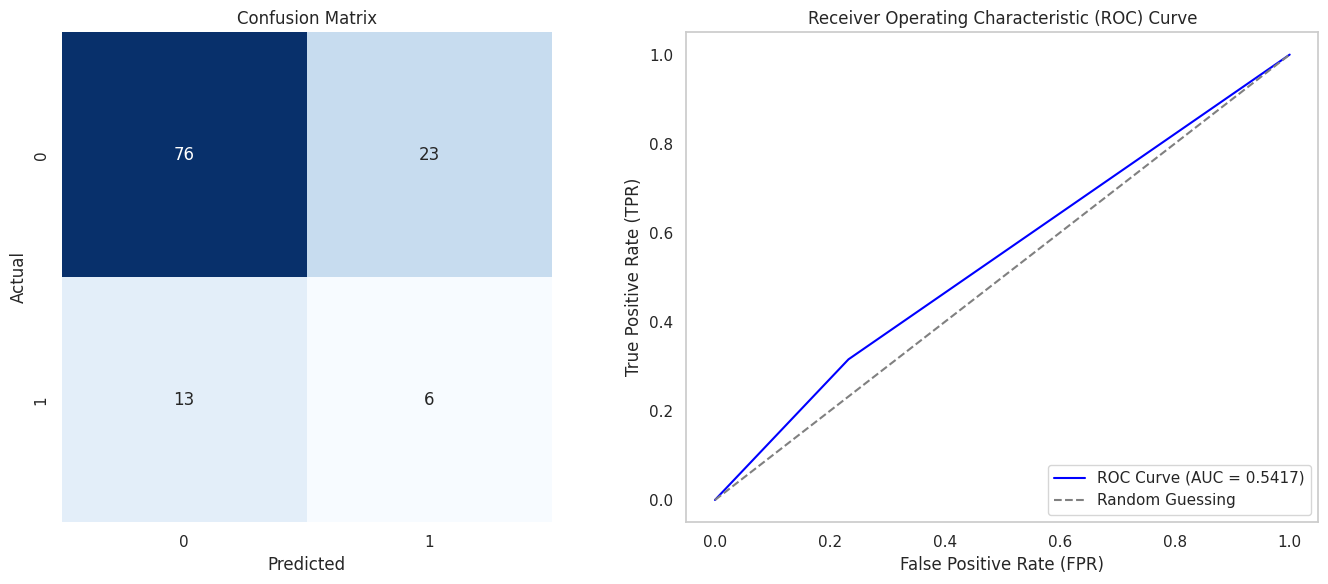



--- XGBoost Classifier ---
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
classification report: 
               precision    recall  f1-score   support

           0       0.86      0.85      0.85        99
           1       0.25      0.26      0.26        19

    accuracy                           0.75       118
   macro avg       0.55      0.56      0.55       118
weighted avg       0.76      0.75      0.76       118



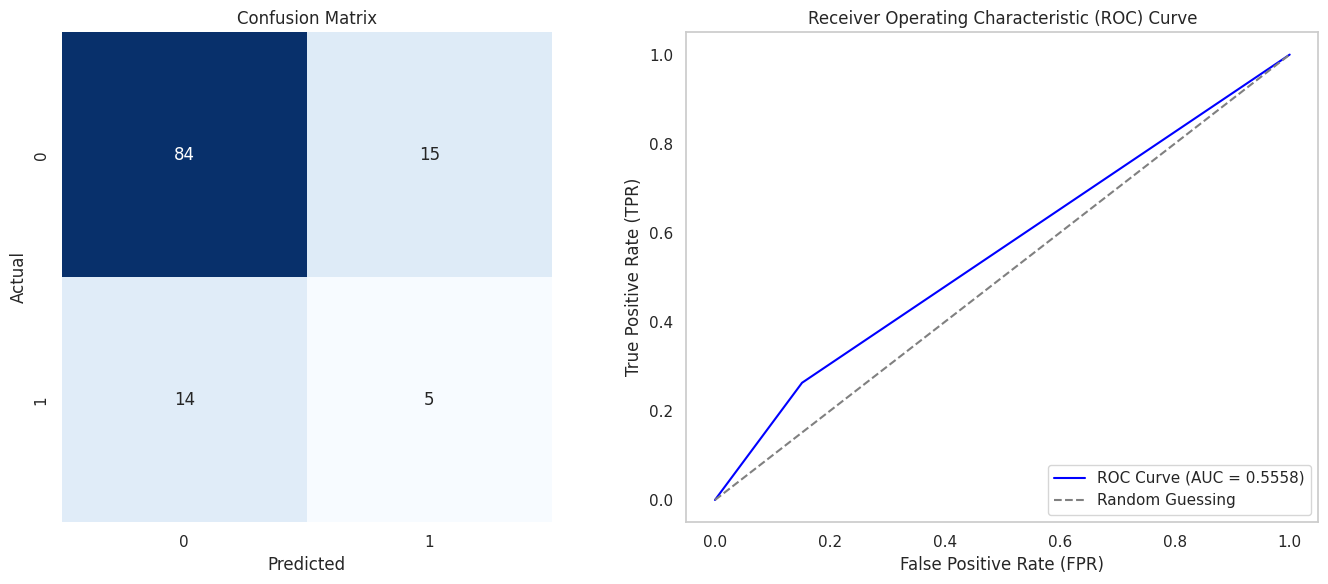

Exception ignored in: <function ResourceTracker.__del__ at 0x7511a7b75c60>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7a9adb175c60>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x78d32c671c60>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/reso

In [84]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
f1_label_1 = make_scorer(f1_score, pos_label=1, average="binary")

param_grids = {

    'Decision Tree Classifier': ({
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }, DecisionTreeClassifier(random_state=42)),

    'Random Forest Classifier': ({
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }, RandomForestClassifier(class_weight='balanced', random_state=42)),

    'KNN Classifier': ({
        'n_neighbors': range(1, 11),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  
    }, KNeighborsClassifier()),

    'SVM (Support Vector Classification)': ({
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }, SVC(random_state=42)),

    'XGBoost Classifier': ({
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }, XGBClassifier(random_state=42)),
}

for name, (param_grid, model) in param_grids.items():
    print(f"--- {name} ---")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=f1_label_1,
        cv=kf,
        n_jobs=-1
    )
    """ 
    if name in ['SVR (Support Vector Regression)', 'KNN Regressor']:
        grid_search.fit(X_train_scaled, y_train)
    else:
        grid_search.fit(X_train_scaled, y_train, sample_weight=sample_weight) 
    """
    grid_search.fit(X_train_scaled, y_train)

    print("Best params:", grid_search.best_params_)

    y_pred = grid_search.best_estimator_.predict(X_test_scaled)
    evaluation3(y_test, y_pred)

    print("\n")

## Final Conclusion

This project built a regression model to predict ICU Length of Stay using MIMIC-III patient data. After evaluating multiple algorithms, the Random Forest Regressor was selected for its strong balance of accuracy and robustness.

By applying SHAP, we confirmed that the model bases its predictions on clinically meaningful features (e.g., blood pressure, BUN, heart rate). This interpretability step adds essential transparency and reliability, making the model more suitable for real-world clinical decision support.


### Analysis of Results and Interpretation